In [12]:
import datetime
from pyhive import hive
from pyecharts import options as opts

from pyecharts.charts import Bar, Grid, Line, Liquid, Page, Pie, Map,Gauge
from pyecharts.commons.utils import JsCode
from pyecharts.components import Table
import datetime
from pyecharts.globals import ThemeType
from pyecharts.charts import Geo
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Songti SC']
import plotly.express as px
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.subplots as sp

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier #导入Xgboost
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,auc,confusion_matrix# 导入模型评价指标
from sklearn.model_selection import GridSearchCV #网格搜索
from sklearn.linear_model import LogisticRegression #导入逻辑回归模型

from imblearn.over_sampling import SMOTE #导入过采样算法

In [13]:
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import gc
import warnings


from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

# 设置正常显示符号
mpl.rcParams["axes.unicode_minus"] = False
warnings.filterwarnings('ignore')

In [14]:
test_data = pd.read_csv('./data_format1/test_format1.csv')
train_data = pd.read_csv('./data_format1/train_format1.csv')

user_info = pd.read_csv('./data_format1/user_info_format1.csv')
user_log = pd.read_csv('./data_format1/user_log_format1.csv')

In [15]:
# reduce memory
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
               
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [16]:
train_data = reduce_mem_usage(train_data)
test_data = reduce_mem_usage(test_data)

user_info = reduce_mem_usage(user_info)
user_log = reduce_mem_usage(user_log)

Memory usage after optimization is: 1.74 MB
Decreased by 70.8%
Memory usage after optimization is: 3.49 MB
Decreased by 41.7%
Memory usage after optimization is: 3.24 MB
Decreased by 66.7%
Memory usage after optimization is: 890.48 MB
Decreased by 69.6%


用户复购品类分析

In [17]:
#用户日志信息
user_log=pd.read_csv("./data_format1/user_log_format1.csv")
user_info=pd.read_csv("./data_format1/user_info_format1.csv")
test_data=pd.read_csv("./data_format1/test_format1.csv")
train_data=pd.read_csv("./data_format1/train_format1.csv")

In [18]:
user_log["time_stamp"] =user_log["time_stamp"].astype(str).str.zfill(4)  # 在左侧填充0，使得长度为4
user_log["time_stamp"]=pd.to_datetime(user_log["time_stamp"],format="%m%d").dt.strftime("%m-%d")
user_log.head()

user_id  item_id  cat_id  seller_id  brand_id time_stamp  action_type
0   328862   323294     833       2882    2661.0      08-29            0
1   328862   844400    1271       2882    2661.0      08-29            0
2   328862   575153    1271       2882    2661.0      08-29            0
3   328862   996875    1271       2882    2661.0      08-29            0
4   328862  1086186    1271       1253    1049.0      08-29            0

In [19]:
user_pl_11=pd.DataFrame()
user_pl_11["cat_id"]=user_log.query("action_type==2 and time_stamp=='11-11'").groupby("cat_id").count().index.tolist()
user_pl_11.set_index("cat_id",inplace=True)
user_pl_11["user_list"]=user_log.query("action_type==2 and time_stamp=='11-11'").groupby("cat_id").apply(lambda x:x["user_id"].unique())

user_pl_not11=pd.DataFrame()
user_pl_not11["cat_id"]=user_log.query("action_type==2 and time_stamp<'11-11'").groupby("cat_id").count().index.tolist()
user_pl_not11.set_index("cat_id",inplace=True)
user_pl_not11["user_list"]=user_log.query("action_type==2 and time_stamp<'11-11'").groupby("cat_id").apply(lambda x:x["user_id"].unique())
user_pl_join=pd.merge(user_pl_not11,user_pl_11,left_index=True,right_index=True,how="left")
user_pl_join["user_list_y"]=user_pl_join["user_list_y"].fillna("[]")
# # 计算复购用户的双11复购品类
user_pl_join["user_list_join"]=user_pl_join.apply(lambda row: list(set(row['user_list_x']) & set(row['user_list_y']))
                ,axis=1)
user_pl_join["purchase cnt"]=user_pl_join["user_list_x"].apply(lambda x:len(x))
user_pl_join["Repurchase rate"]=user_pl_join.apply(lambda row:len(row["user_list_join"])/len(row["user_list_x"]),axis=1)
user_pl_join.sort_values(by="Repurchase rate",ascending=False,inplace=True)
user_pl_join.head()

user_list_x  \
cat_id                                                      
898     [186568, 2859, 343130, 226647, 179098, 145968,...   
1528    [370679, 258031, 330993, 7060, 6539, 182451, 3...   
924         [342608, 50244, 123391, 82244, 389044, 92189]   
656     [300681, 370015, 337277, 166453, 249869, 21500...   
420     [109881, 160113, 80721, 251260, 358360, 258538...   

                                              user_list_y  \
cat_id                                                      
898     [186568, 153790, 383227, 261596, 166453, 34030...   
1528    [370679, 258031, 414256, 74839, 283320, 7060, ...   
924                      [314657, 332835, 123391, 150860]   
656     [37908, 153790, 401805, 219316, 241618, 248997...   
420     [80721, 308386, 214182, 144854, 422917, 73709,...   

                                           user_list_join  purchase cnt  \
cat_id                                                                    
898     [262147, 344070, 327691, 98333, 73758, 36, 122...          8227   
1528    [77829, 335879, 131082, 12298, 124943, 77839, ...          2608   
924                                              [123391]             6   
656     [229377, 163843, 204819, 385048, 81955, 8228, ...         13620   
420     [229376, 385025, 376844, 221196, 327702, 81949...         15018   

        Repurchase rate  
cat_id                   
898            0.273733  
1528           0.261503  
924            0.166667  
656            0.162922  
420            0.158010

In [20]:
#绘制品类的购买用户数以及复购率
bar_fgpl=Bar(init_opts=opts.InitOpts(theme=ThemeType.DARK))
bar_fgpl.add_xaxis(user_pl_join.index.astype("str").tolist())
bar_fgpl.add_yaxis("购买用户数",user_pl_join["purchase cnt"].tolist(),z_level=1)
bar_fgpl.extend_axis(
            yaxis=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}"),interval=5)
    )
bar_fgpl.set_global_opts(title_opts=opts.TitleOpts(title="双11复购品类分析")
                        ,yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
#                        toolbox_opts=opts.ToolboxOpts() #显示工具箱
                       )
line_fgpl=Line()
line_fgpl.add_xaxis(user_pl_join.index.astype("str").tolist())
line_fgpl.add_yaxis("复购率",round(user_pl_join["Repurchase rate"],2).tolist(),is_smooth=True,yaxis_index=1,
#                   label_opts=opts.LabelOpts(formatter="{value}%"),
                  linestyle_opts=opts.LineStyleOpts(color="red",width=3),z_level=2# 设置折线图的图层为3，确保显示在柱状图上方
                 ,markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(y=user_pl_join["Repurchase rate"].quantile(0.8) , name="80%分位数"),]
        ),
                   )
line_fgpl.set_global_opts(yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")
                                                  ,splitline_opts=opts.SplitLineOpts(is_show=True)),
                        )
# 将柱状图和折线图组合在一起
chart=bar_fgpl.overlap(line_fgpl)

chart.render_notebook()


In [21]:
#绘制品牌复购率分布图
fig = go.Figure(data=go.Histogram(x=user_pl_join["Repurchase rate"], nbinsx=30))
fig.update_layout(barmode="overlay")
fig.show()

In [22]:
#复购率非0的品牌占比
user_pl_join[user_pl_join["Repurchase rate"]>0].shape[0]/user_pl_join.shape[0]

0.44753086419753085

In [23]:
#第20%的品牌的累计复购用户占比
(user_pl_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_pl_join["user_list_join"].apply(lambda x:len(x)).sum()).quantile(0.2)

0.9624213302692398

In [24]:
#绘制品牌累计复购用户分布曲线(按复购率对品类降序)
bar_fgpl_1=Line(init_opts=opts.InitOpts(theme=ThemeType.DARK))
bar_fgpl_1.add_xaxis((user_pl_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_pl_join["user_list_join"].apply(lambda x:len(x)).sum()).index.astype("str").tolist())
bar_fgpl_1.add_yaxis("累计百分比",(user_pl_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_pl_join["user_list_join"].apply(lambda x:len(x)).sum()).tolist(),z_level=1
                    ,markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(y=(user_pl_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_pl_join["user_list_join"].apply(lambda x:len(x)).sum()).quantile(0.2) , name="20%分位数")]
        ),linestyle_opts=opts.LineStyleOpts(color="red",width=3)
                    
                    )

bar_fgpl_1.set_global_opts(title_opts=opts.TitleOpts(title="双11品类复购用户累计分布曲线")
                        ,yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
#                        toolbox_opts=opts.ToolboxOpts() #显示工具箱
                       )

bar_fgpl_1.render_notebook()

用户双11对大部分品类的复购偏好低，复购用户的品牌偏好呈现集中趋势(一共1296个品类，80%左右的品类复购率低于2%，55%左右的品类复购率为0,复购率前20%的品牌拥有96%的复购用户)，建议来年双11前优先给购买用户推送头部品牌，同时对80%的非头部品牌进行专项分析，优化产品结构。

用户复购商家分析

In [25]:
user_sj_11=pd.DataFrame()
user_sj_11["seller_id"]=user_log.query("action_type==2 and time_stamp=='11-11'").groupby("seller_id").count().index.tolist()
user_sj_11.set_index("seller_id",inplace=True)
user_sj_11["user_list"]=user_log.query("action_type==2 and time_stamp=='11-11'").groupby("seller_id").apply(lambda x:x["user_id"].unique())

user_sj_not11=pd.DataFrame()
user_sj_not11["seller_id"]=user_log.query("action_type==2 and time_stamp<'11-11'").groupby("seller_id").count().index.tolist()
user_sj_not11.set_index("seller_id",inplace=True)
user_sj_not11["user_list"]=user_log.query("action_type==2 and time_stamp<'11-11'").groupby("seller_id").apply(lambda x:x["user_id"].unique())
user_sj_join=pd.merge(user_sj_not11,user_sj_11,left_index=True,right_index=True,how="left")
user_sj_join["user_list_y"]=user_sj_join["user_list_y"].fillna("[]")
# # 计算复购用户的双11复购商家
user_sj_join["user_list_join"]=user_sj_join.apply(lambda row: list(set(row['user_list_x']) & set(row['user_list_y']))
                ,axis=1)
user_sj_join["purchase cnt"]=user_sj_join["user_list_x"].apply(lambda x:len(x))
user_sj_join["Repurchase rate"]=user_sj_join.apply(lambda row:len(row["user_list_join"])/len(row["user_list_x"]),axis=1)
user_sj_join.sort_values(by="Repurchase rate",ascending=False,inplace=True)
user_sj_join.head()

user_list_x  \
seller_id                                                      
3354       [283272, 184959, 332466, 6492, 74455, 189960, ...   
2092       [387790, 133406, 51143, 290754, 28935, 81643, ...   
2849       [169958, 354209, 201920, 184000, 135866, 33625...   
42         [161593, 118707, 303692, 326278, 363000, 22028...   
1104       [294220, 216868, 247906, 204606, 319140, 39720...   

                                                 user_list_y  \
seller_id                                                      
3354       [283272, 273332, 94329, 207148, 332466, 279808...   
2092       [387790, 51143, 132905, 290754, 411321, 372147...   
2849       [64183, 201515, 17162, 316952, 66819, 423749, ...   
42         [409035, 225723, 115862, 161593, 72111, 175884...   
1104       [330, 41271, 251470, 174908, 359383, 259368, 4...   

                                              user_list_join  purchase cnt  \
seller_id                                                                    
3354       [421121, 100870, 350854, 283272, 263943, 13261...           133   
2092       [355841, 356100, 28935, 350471, 101908, 201749...            94   
2849       [336256, 372352, 341264, 39312, 144913, 187287...            70   
42                                  [161593, 118707, 400123]             9   
1104       [214562, 247906, 216868, 344338, 41591, 397208...            25   

           Repurchase rate  
seller_id                   
3354              0.398496  
2092              0.393617  
2849              0.342857  
42                0.333333  
1104              0.320000

In [26]:
#绘制商家的购买用户数以及复购率
bar_fgsj=Bar(init_opts=opts.InitOpts(theme=ThemeType.DARK))
bar_fgsj.add_xaxis(user_sj_join.index.astype("str").tolist())
bar_fgsj.add_yaxis("购买用户数",user_sj_join["purchase cnt"].tolist(),z_level=1)
bar_fgsj.extend_axis(
            yaxis=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}"),interval=5)
    )
bar_fgsj.set_global_opts(title_opts=opts.TitleOpts(title="双11复购商家分析")
                        ,yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
#                        toolbox_opts=opts.ToolboxOpts() #显示工具箱
                       )
line_fgsj=Line()
line_fgsj.add_xaxis(user_sj_join.index.astype("str").tolist())
line_fgsj.add_yaxis("复购率",round(user_sj_join["Repurchase rate"],2).tolist(),is_smooth=True,yaxis_index=1,
#                   label_opts=opts.LabelOpts(formatter="{value}%"),
                  linestyle_opts=opts.LineStyleOpts(color="red",width=3),z_level=2# 设置折线图的图层为3，确保显示在柱状图上方
                 ,markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(y=user_sj_join["Repurchase rate"].quantile(0.8) , name="80%分位数"),
                 opts.MarkLineItem(y=user_sj_join["Repurchase rate"].mean() , name="均值")
                 ]
        ),
                   )
line_fgsj.set_global_opts(yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")
                                                  ,splitline_opts=opts.SplitLineOpts(is_show=True)),
                        )
# 将柱状图和折线图组合在一起
chart_sj=bar_fgsj.overlap(line_fgsj)

chart_sj.render_notebook()


In [27]:
#绘制品牌复购率分布图
fig_sj = go.Figure(data=go.Histogram(x=user_sj_join["Repurchase rate"], nbinsx=30,histnorm="probability"))
fig_sj.update_layout(barmode="overlay")
fig_sj.show()

In [28]:
#复购率非0的商家占比
user_sj_join[user_sj_join["Repurchase rate"]>0].shape[0]/user_sj_join.shape[0]

0.6571142284569138

In [29]:
#前20%的商家的累计复购用户占比
(user_sj_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_sj_join["user_list_join"].apply(lambda x:len(x)).sum()).quantile(0.2)

0.7540096143340981

In [30]:
#绘制商家累计复购用户分布曲线(按复购率对商家降序)
bar_fgsj_1=Line(init_opts=opts.InitOpts(theme=ThemeType.DARK))
bar_fgsj_1.add_xaxis((user_sj_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_sj_join["user_list_join"].apply(lambda x:len(x)).sum()).index.astype("str").tolist())
bar_fgsj_1.add_yaxis("累计百分比",round((user_sj_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_sj_join["user_list_join"].apply(lambda x:len(x)).sum()),2).tolist(),z_level=1
                    ,markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(y=(user_sj_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_sj_join["user_list_join"].apply(lambda x:len(x)).sum()).quantile(0.2) , name="20%分位数")]
        ),linestyle_opts=opts.LineStyleOpts(color="red",width=3)
                    
                    )

bar_fgsj_1.set_global_opts(title_opts=opts.TitleOpts(title="双11商家复购用户累计分布曲线")
                        ,yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
#                        toolbox_opts=opts.ToolboxOpts() #显示工具箱
                       )

bar_fgsj_1.render_notebook()

用户双11对商家的复购偏好差，复购用户对商家的集中性不显著(80%的商家复购率低于3%，35%的商家无复购，20%的头部商家拥有75%的复购用户)，下次双11可以考虑加大对头部前20%商家商品的推送和促销，对于复购率为0的商家应加大对商品质量和品类结构的优化。

用户复购品牌分析

In [31]:
user_pp_11=pd.DataFrame()
user_pp_11["brand_id"]=user_log.query("action_type==2 and time_stamp=='11-11'").groupby("brand_id").count().index.tolist()
user_pp_11.set_index("brand_id",inplace=True)
user_pp_11["user_list"]=user_log.query("action_type==2 and time_stamp=='11-11'").groupby("brand_id").apply(lambda x:x["user_id"].unique())

user_pp_not11=pd.DataFrame()
user_pp_not11["brand_id"]=user_log.query("action_type==2 and time_stamp<'11-11'").groupby("brand_id").count().index.tolist()
user_pp_not11.set_index("brand_id",inplace=True)
user_pp_not11["user_list"]=user_log.query("action_type==2 and time_stamp<'11-11'").groupby("brand_id").apply(lambda x:x["user_id"].unique())
user_pp_join=pd.merge(user_pp_not11,user_pp_11,left_index=True,right_index=True,how="left")
user_pp_join["user_list_y"]=user_pp_join["user_list_y"].fillna("[]")
# # 计算复购用户的双11复购品牌
user_pp_join["user_list_join"]=user_pp_join.apply(lambda row: list(set(row['user_list_x']) & set(row['user_list_y']))
                ,axis=1)
user_pp_join["purchase cnt"]=user_pp_join["user_list_x"].apply(lambda x:len(x))
user_pp_join["Repurchase rate"]=user_pp_join.apply(lambda row:len(row["user_list_join"])/len(row["user_list_x"]),axis=1)
user_pp_join.sort_values(by="Repurchase rate",ascending=False,inplace=True)
user_pp_join.head()

user_list_x                                        user_list_y  \
brand_id                                                                       
4255.0           [285539]  [361145, 390611, 163577, 51917, 15665, 183225,...   
981.0            [418182]  [162712, 139833, 213759, 180742, 418182, 33384...   
727.0            [258557]                                   [258557, 253866]   
4118.0           [217803]  [228845, 5438, 257120, 157302, 256303, 211893,...   
6571.0    [222417, 73066]  [222417, 16365, 119711, 129477, 231747, 230079...   

         user_list_join  purchase cnt  Repurchase rate  
brand_id                                                
4255.0         [285539]             1              1.0  
981.0          [418182]             1              1.0  
727.0          [258557]             1              1.0  
4118.0         [217803]             1              1.0  
6571.0         [222417]             2              0.5

In [32]:
#绘制品牌的购买用户数以及复购率
bar_fgpp=Bar(init_opts=opts.InitOpts(theme=ThemeType.DARK))
bar_fgpp.add_xaxis(user_pp_join.index.astype("str").tolist())
bar_fgpp.add_yaxis("购买用户数",user_pp_join["purchase cnt"].tolist(),z_level=1)
bar_fgpp.extend_axis(
            yaxis=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}"),interval=5)
    )
bar_fgpp.set_global_opts(title_opts=opts.TitleOpts(title="双11复购品牌分析")
                        ,yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
#                        toolbox_opts=opts.ToolboxOpts() #显示工具箱
                       )
line_fgpp=Line()
line_fgpp.add_xaxis(user_pp_join.index.astype("str").tolist())
line_fgpp.add_yaxis("复购率",round(user_pp_join["Repurchase rate"],2).tolist(),is_smooth=True,yaxis_index=1,
#                   label_opts=opts.LabelOpts(formatter="{value}%"),
                  linestyle_opts=opts.LineStyleOpts(color="red",width=3),z_level=2# 设置折线图的图层为3，确保显示在柱状图上方
                 ,markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(y=user_pp_join["Repurchase rate"].quantile(0.8) , name="80%分位数",),
                 opts.MarkLineItem(y=user_pp_join["Repurchase rate"].quantile(0.4) , name="40%分位数")
                 ]
        ),
                   )
line_fgpp.set_global_opts(yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")
                                                  ,splitline_opts=opts.SplitLineOpts(is_show=True)),
                          
                        )

# 将柱状图和折线图组合在一起
chart_pp=bar_fgpp.overlap(line_fgpp)
#添加数值标签
# chart.set_series_opts(
# label_opts=opts.LabelOpts(
#     is_show=True,
#     position="top",
#     formatter="{c}"
# )
# )


chart_pp.render_notebook()

In [33]:
#绘制品牌复购率分布图
fig_pp = go.Figure(data=go.Histogram(x=user_pp_join["Repurchase rate"], nbinsx=30,histnorm="probability"))
fig_pp.update_layout(barmode="overlay")
fig_pp.show()

In [34]:
#复购率非0的品牌占比
user_pp_join[user_pp_join["Repurchase rate"]>0].shape[0]/user_pp_join.shape[0]

0.4438914027149321

In [35]:
#前20%的品牌的累计复购用户占比
(user_pp_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_pp_join["user_list_join"].apply(lambda x:len(x)).sum()).quantile(0.2)

0.8451492006262158

In [36]:
#绘制商家累计复购用户分布曲线(按复购率对商家降序)
bar_fgpp_1=Line(init_opts=opts.InitOpts(theme=ThemeType.DARK))
bar_fgpp_1.add_xaxis((user_pp_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_pp_join["user_list_join"].apply(lambda x:len(x)).sum()).index.astype("str").tolist())
bar_fgpp_1.add_yaxis("累计百分比",round((user_pp_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_pp_join["user_list_join"].apply(lambda x:len(x)).sum()),2).tolist(),z_level=1
                    ,markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(y=(user_pp_join["user_list_join"].apply(lambda x:len(x)).cumsum()/user_pp_join["user_list_join"].apply(lambda x:len(x)).sum()).quantile(0.2) , name="20%分位数")]
        ),linestyle_opts=opts.LineStyleOpts(color="red",width=3)
                    
                    )

bar_fgpp_1.set_global_opts(title_opts=opts.TitleOpts(title="双11品牌复购用户累计分布曲线")
                        ,yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
#                        toolbox_opts=opts.ToolboxOpts() #显示工具箱
                       )

bar_fgpp_1.render_notebook()

用户双11当天对大部分品牌的复购偏好低，品牌偏好呈现集中趋势(一共6630个品牌，80%的品牌复购率低于2%，55%的品牌复购为0，头部20%品牌拥有85%的复购用户)，建议来年双11前对购买用户投放top20%品牌的广告/促销等活动；同时针对尾部55%的复购为0的品牌进行专项分析，优化产品结构和质量

#### 用户复购间隔分析

In [37]:
# 圈定双11的复购用户
user_period_11=user_log.query("action_type==2 and time_stamp=='11-11'").groupby("user_id").agg({"time_stamp":"max"})
user_period_11.columns=["end_time"]
user_period_11

end_time
user_id         
1          11-11
2          11-11
3          11-11
4          11-11
5          11-11
...          ...
424166     11-11
424167     11-11
424168     11-11
424169     11-11
424170     11-11

[424170 rows x 1 columns]

In [38]:
user_period_not11=user_log.query("action_type==2 and time_stamp<'11-11'").groupby("user_id").agg({"time_stamp":"max"})
user_period_not11.columns=["start_time"]
user_period_not11

start_time
user_id           
1            10-21
2            10-10
3            08-19
5            10-29
6            11-08
...            ...
424163       06-19
424166       11-09
424167       11-08
424168       11-03
424169       11-10

[340758 rows x 1 columns]

In [39]:
user_period_agg=pd.merge(user_period_not11,user_period_11,left_index=True,right_index=True,how="left")
user_period_agg["label"]=user_period_agg.apply(lambda x:0 if pd.isnull(x["end_time"]) else 1,axis=1)
user_period_agg["end_time"]="11-11"
user_period_agg["date_diff"]=(pd.to_datetime(user_period_agg['end_time'], format='%m-%d')-pd.to_datetime(user_period_agg['start_time'], format='%m-%d')).dt.days
user_period_agg["label"].value_counts()

label
1    340758
Name: count, dtype: int64

In [40]:
#对datediff以7天为间隔，进行分段
user_period_agg["date_diff_wk"]=(user_period_agg["date_diff"]-1)//7+1

In [41]:
#   - 绘制时间差与复购用户数_的曲线图
user_period_count=pd.DataFrame()
user_period_count.index=user_period_agg['date_diff_wk'].value_counts().sort_index().index
user_period_count["purchase cnt"]=user_period_agg['date_diff_wk'].value_counts().sort_index()
user_period_count["Cumulative percentage"]=user_period_count["purchase cnt"].cumsum()/user_period_count["purchase cnt"].sum()*100

# 使用pyecharts绘制曲线图
bar_period=Line(init_opts=opts.InitOpts(theme=ThemeType.DARK))
bar_period.add_xaxis(user_period_count.index.astype("str").tolist())
bar_period.add_yaxis("复购用户数",user_period_count["purchase cnt"].tolist(),linestyle_opts=opts.LineStyleOpts(width=3), is_smooth=True)
bar_period.extend_axis(
            yaxis=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}"),interval=5)
    )
bar_period.set_global_opts(title_opts=opts.TitleOpts(title="双11复购用户复购时间间隔分布")
                        ,yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
#                        toolbox_opts=opts.ToolboxOpts() #显示工具箱
                       )
line_period=Line()
line_period.add_xaxis(user_period_count.index.astype("str").tolist())
line_period.add_yaxis("累计百分比",round(user_period_count["Cumulative percentage"],2).tolist(),is_smooth=True,yaxis_index=1,
#                   label_opts=opts.LabelOpts(formatter="{value}%"),
                  linestyle_opts=opts.LineStyleOpts(color="red",width=3)# 设置折线图的图层为3，确保显示在柱状图上方
                 ,markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(y=80, name="80%"),]
        ),
                   )
line_period.set_global_opts(yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")
                                                  ,splitline_opts=opts.SplitLineOpts(is_show=True)),
                        )
# 将柱状图和折线图组合在一起
chart_period=bar_period.overlap(line_period)
#添加数值标签
# chart.set_series_opts(
# label_opts=opts.LabelOpts(
#     is_show=True,
#     position="top",
#     formatter="{c}"
# )
# )
chart_period.render_notebook()

复购间隔==6周可以作为复购流失的拐点（复购用户随复购间隔的增加而减少，在6周之前出现显著的梯度下降，在6周之后梯度变化趋于平缓），80%的用户会在12周内再次复购，建议双11前对购买6周以内的用户及时做复购触达，对购买6周以上的用户作为召回广告/促销活动等召回干预

#### 用户复购频率分析

In [42]:
## 获取双11前每个用户的累计购买天数
user_buy_fq=pd.DataFrame()
user_buy_fq.index=user_log.query("action_type==2 and time_stamp<'11-11'").groupby("user_id").count().index
user_buy_fq["累计购买天数"]=user_log.query("action_type==2 and time_stamp<'11-11'").groupby("user_id").agg({"time_stamp":pd.Series.nunique})
user_buy_fq.head()

user_buy_11=pd.DataFrame()
user_buy_11.index=user_log.query("action_type==2 and time_stamp=='11-11'").groupby("user_id").count().index
user_buy_11["count"]=user_log.query("action_type==2 and time_stamp=='11-11'").groupby("user_id").agg({"user_id":"count"})
user_buy_agg=pd.merge(user_buy_fq,user_buy_11,left_index=True,right_index=True,how="left")
user_buy_agg["是否复购"]=user_buy_agg.apply(lambda x:0 if pd.isnull(x["count"]) else 1,axis=1)
user_buy_agg

累计购买天数  count  是否复购
user_id                     
1             2      4     1
2             4      7     1
3             2      1     1
5             6      3     1
6            11      2     1
...         ...    ...   ...
424163        2      2     1
424166        7      1     1
424167        4      2     1
424168        3      1     1
424169       10      1     1

[340758 rows x 3 columns]

In [43]:
#   - 绘制累计购买天数与复购用户数_的曲线图
user_buy_count=pd.DataFrame()
user_buy_count.index=user_buy_agg['累计购买天数'].value_counts().sort_index().index
user_buy_count["复购用户数"]=user_buy_agg['累计购买天数'].value_counts().sort_index()
user_buy_count["累计百分比"]=user_buy_count["复购用户数"].cumsum()/user_buy_count["复购用户数"].sum()*100

# 使用pyecharts绘制曲线图
bar_buy=Line(init_opts=opts.InitOpts(theme=ThemeType.DARK))
bar_buy.add_xaxis(user_buy_count.index.astype("str").tolist())
bar_buy.add_yaxis("复购用户数",user_buy_count["复购用户数"].tolist(),linestyle_opts=opts.LineStyleOpts(width=3), is_smooth=True)
bar_buy.extend_axis(
            yaxis=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}"),interval=5)
    )
bar_buy.set_global_opts(title_opts=opts.TitleOpts(title="双11复购用户购买频率分布")
                        ,yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
#                        toolbox_opts=opts.ToolboxOpts() #显示工具箱
                       )
line_buy=Line()
line_buy.add_xaxis(user_buy_count.index.astype("str").tolist())
line_buy.add_yaxis("累计百分比",round(user_buy_count["累计百分比"],2).tolist(),is_smooth=True,yaxis_index=1,
#                   label_opts=opts.LabelOpts(formatter="{value}%"),
                  linestyle_opts=opts.LineStyleOpts(color="red",width=3)#,z_level=2# 设置折线图的图层为3，确保显示在柱状图上方
                 ,markline_opts=opts.MarkLineOpts(
            data=[opts.MarkLineItem(y=80, name="80%"),]
        ),
                   )
line_buy.set_global_opts(yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")
                                                  ,splitline_opts=opts.SplitLineOpts(is_show=True)),
                        )
# 将柱状图和折线图组合在一起
chart_buy=bar_buy.overlap(line_buy)
#添加数值标签
# chart.set_series_opts(
# label_opts=opts.LabelOpts(
#     is_show=True,
#     position="top",
#     formatter="{c}"
# )
# )
chart_buy.render_notebook()

双11复购群体主要是首购用户（首购用户占比最高为25%，80%的用户累计购买天数在6天以内），下次双11可以重点优化对首购用户的商品推荐、促销活动，让首购用户再次购买。

### 复购行为分析

研究用户双11前点击、加购、收藏、购买商品与用户再次购买此商品的关系

#### 用户点击复购分析

研究双11前用户点击商品累计天数与用户再次复购此商品的关系

**分析过程**

  1、得出双11用户复购商品的数据：双11用户发生购买行为的商品数据 a(唯一字段：用户id、商品id、购买时间)</br>
  2、得出双11前用户最近一次购买的商品在之后的累计点击天数数据 b（字段：用户id，商品id，最近一次购买时间，最近一次购买时间）</br>
  3、b和a左连接(用户id，商品id为连接字段)，新增一列判断是否复购(a.购买时间为空则为0，否则为1),最终字段为(用户id、商品id、最近一次购买时间、最近一次购买时间、是否复购) ，为表c</br>
  4、计算不同累计点击天数下的购买用户数以及复购率，并以累计点击天数为横轴，购买用户数以及复购率为纵轴绘制曲线图，研究累计点击天数下的购买用户数以及复购率的关系

In [44]:
click_not11=user_log.query("time_stamp<'11-11' and action_type==2").groupby(["user_id","item_id"]).agg({"time_stamp":"max"})
#获取双11前用户最近一次购买的商品在之后的累计点击天数
click_cum= user_log.query("action_type==0")[["user_id","item_id","time_stamp"]].drop_duplicates()
click_cum.set_index(["user_id","item_id"],inplace=True)
click_cum_date=pd.merge(click_not11,click_cum,left_index=True,right_index=True,how="left")
click_cum_date=click_cum_date
click_cum_date["click_type"]=click_cum_date.apply(lambda x:0 if pd.isnull(x["time_stamp_y"]) else (
        1 if x["time_stamp_x"]<x["time_stamp_y"] else 2
),axis=1)
click_cum_date=click_cum_date.query("click_type!=2")
click_cum_date.reset_index(inplace=True)
click_cum_agg=pd.DataFrame()
click_cum_agg.index=click_cum_date.groupby(["user_id","item_id"]).count().index
click_cum_agg["time_stamp"]=click_cum_date.groupby(["user_id","item_id"]).agg({"time_stamp_x":"max"})
click_cum_agg["click_day_cnt"]=click_cum_date.groupby(["user_id","item_id"]).agg({"click_type":"sum"})
##得出双11用户复购商品的数据
click_11=user_log.query("time_stamp=='11-11' and action_type==2").groupby(["user_id","item_id"]).agg({"time_stamp":"max"})
click_agg=pd.merge(click_cum_agg,click_11,left_index=True,right_index=True,how="left")
click_agg["label"]=click_agg.apply(lambda x: 0 if pd.isnull(x["time_stamp_y"]) else 1,axis=1)
# 获取双11前用户最近一次购买的商品在之后的点击累计天数以及商品是否复购
click_agg.head(100)

time_stamp_x  click_day_cnt time_stamp_y  label
user_id item_id                                                
2       293244         10-10              0          NaN      0
        917794         10-10              0          NaN      0
        1068315        07-21              0          NaN      0
3       895754         05-16              0          NaN      0
        946314         08-19              1          NaN      0
...                      ...            ...          ...    ...
40      116973         08-26              0          NaN      0
        221934         08-12              0          NaN      0
        357388         09-05              0          NaN      0
        492518         06-19              1          NaN      0
        545298         08-24              0          NaN      0

[100 rows x 4 columns]

In [45]:
# 得到每个累计天数下的购买商品数以及商品的复购率
click_end=click_agg.groupby("click_day_cnt").agg({"click_day_cnt":"count","label":"sum"}).rename(columns={"click_day_cnt":"购买商品数","label":"复购商品数"})
click_end["复购率"]=click_end["复购商品数"]/click_end["购买商品数"]
click_end

购买商品数  复购商品数       复购率
click_day_cnt                         
0              308902    467  0.001512
1              349082   3591  0.010287
2               82462   1993  0.024169
3               24301    931  0.038311
4                8734    410  0.046943
5                3678    204  0.055465
6                1733     96  0.055395
7                 901     56  0.062153
8                 514     30  0.058366
9                 311     19  0.061093
10                189     10  0.052910
11                116      5  0.043103
12                 84      3  0.035714
13                 58      3  0.051724
14                 28      0  0.000000
15                 34      1  0.029412
16                 21      1  0.047619
17                 16      1  0.062500
18                 12      1  0.083333
19                  7      0  0.000000
20                  8      1  0.125000
21                  8      1  0.125000
22                  5      0  0.000000
23                  2      0  0.000000
25                  2      1  0.500000
26                  3      0  0.000000
27                  3      0  0.000000
28                  1      0  0.000000
29                  1      0  0.000000
30                  2      0  0.000000
33                  1      1  1.000000

In [46]:
#   - 绘制双11前用户最近一次购买商品之后对该商品的累计点击天数与用户再次复购此商品的关系
bar_click=Bar(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
bar_click.add_xaxis(click_end.index.astype("str").tolist())
bar_click.add_yaxis("购买商品数",click_end["购买商品数"].tolist(), color="#6495ED")
bar_click.extend_axis(
            yaxis=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}"),interval=5)
    )
bar_click.set_global_opts(title_opts=opts.TitleOpts(title="商品累计点击天数与商品复购的关系")
                        ,yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
#                        toolbox_opts=opts.ToolboxOpts() #显示工具箱
                       )

line_click=Line()
line_click.add_xaxis(click_end.index.astype("str").tolist())
line_click.add_yaxis("复购率",round(click_end["复购率"],2).tolist(),is_smooth=True,yaxis_index=1,
#                   label_opts=opts.LabelOpts(formatter="{value}%"),
                  linestyle_opts=opts.LineStyleOpts(color="red",width=3)# 设置折线图的图层为3，确保显示在柱状图上方
#                  ,markline_opts=opts.MarkLineOpts(
#             data=[opts.MarkLineItem(y=user_pp_join["Repurchase rate"].quantile(0.8) , name="80%分位数",),
#                  opts.MarkLineItem(y=user_pp_join["Repurchase rate"].quantile(0.4) , name="40%分位数")
#                  ]
#         ),
                   )
line_click.set_global_opts(yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")
                                                  ,splitline_opts=opts.SplitLineOpts(is_show=True)),
                          
                        )

# 将柱状图和折线图组合在一起
chart_click=bar_click.overlap(line_click)
#添加数值标签
# chart.set_series_opts(
# label_opts=opts.LabelOpts(
#     is_show=True,
#     position="top",
#     formatter="{c}"
# )
# )


chart_click.render_notebook()

在0-10的累计点击天数中，随着点击天数的增加，商品的复购率呈上升趋势，在累计点击天数为5天时复购率达到最高为6%，后期持续稳定在6%；建议下次双11可以针对已购买用户设置对已购买商品累计点击不同天数级别的积分或者奖励活动（比如设置[1-2,3-4，>=5]的阶梯式积分或者奖励）

In [47]:
click_end

购买商品数  复购商品数       复购率
click_day_cnt                         
0              308902    467  0.001512
1              349082   3591  0.010287
2               82462   1993  0.024169
3               24301    931  0.038311
4                8734    410  0.046943
5                3678    204  0.055465
6                1733     96  0.055395
7                 901     56  0.062153
8                 514     30  0.058366
9                 311     19  0.061093
10                189     10  0.052910
11                116      5  0.043103
12                 84      3  0.035714
13                 58      3  0.051724
14                 28      0  0.000000
15                 34      1  0.029412
16                 21      1  0.047619
17                 16      1  0.062500
18                 12      1  0.083333
19                  7      0  0.000000
20                  8      1  0.125000
21                  8      1  0.125000
22                  5      0  0.000000
23                  2      0  0.000000
25                  2      1  0.500000
26                  3      0  0.000000
27                  3      0  0.000000
28                  1      0  0.000000
29                  1      0  0.000000
30                  2      0  0.000000
33                  1      1  1.000000

#### 用户加购/收藏复购分析

研究双11前用户最近一次购买商品之后对该商品的累计加购/收藏天数与用户再次复购此商品的关系 

**分析过程**

   1、得出双11用户复购商品的数据：双11用户发生购买行为的商品数据 a(唯一字段：用户id、商品id、购买时间)</br>
  2、得出双11前用户最近一次购买的商品在之后的累计加购/收藏天数数据 b（字段：用户id，商品id，最近一次购买时间）</br>
  3、b和a左连接(用户id，商品id为连接字段)，新增一列判断是否复购(a.购买时间为空则为0，否则为1),最终字段为(用户id、商品id、最近一次购买时间、最近一次购买时间、是否复购) ，为表c</br>
  4、计算不同累计加购/收藏天数下的购买用户数以及复购率，并以累计点击天数为横轴，购买用户数以及复购率为纵轴绘制曲线图，研究累计加购/收藏天数下的购买用户数以及复购率的关系

In [48]:
jgss_not11=user_log.query("time_stamp<'11-11' and action_type==2").groupby(["user_id","item_id"]).agg({"time_stamp":"max"})
#获取双11前用户最近一次购买的商品在之后的累计加购/收藏天数
jgss_cum= user_log.query("action_type in [1,3]")[["user_id","item_id","time_stamp"]].drop_duplicates()
jgss_cum.set_index(["user_id","item_id"],inplace=True)
jgss_cum_date=pd.merge(jgss_not11,jgss_cum,left_index=True,right_index=True,how="left")
jgss_cum_date["jgss_type"]=jgss_cum_date.apply(lambda x:0 if pd.isnull(x["time_stamp_y"]) else (
        1 if x["time_stamp_x"]<x["time_stamp_y"] else 2
),axis=1)
jgss_cum_date=jgss_cum_date.query("jgss_type!=2")
jgss_cum_date.reset_index(inplace=True)
jgss_cum_agg=pd.DataFrame()
jgss_cum_agg.index=jgss_cum_date.groupby(["user_id","item_id"]).count().index
jgss_cum_agg["time_stamp"]=jgss_cum_date.groupby(["user_id","item_id"]).agg({"time_stamp_x":"max"})
jgss_cum_agg["jgss_day_cnt"]=jgss_cum_date.groupby(["user_id","item_id"]).agg({"jgss_type":"sum"})
##得出双11用户复购商品的数据
jgss_11=user_log.query("time_stamp=='11-11' and action_type==2").groupby(["user_id","item_id"]).agg({"time_stamp":"max"})
jgss_agg=pd.merge(jgss_cum_agg,jgss_11,left_index=True,right_index=True,how="left")
jgss_agg["label"]=jgss_agg.apply(lambda x: 0 if pd.isnull(x["time_stamp_y"]) else 1,axis=1)
# 获取双11前用户最近一次购买的商品在之后的加购/收藏累计天数以及商品是否复购
jgss_agg.head(100)

time_stamp_x  jgss_day_cnt time_stamp_y  label
user_id item_id                                               
1       112203         10-21             0          NaN      0
        504149         10-11             0          NaN      0
2       239288         06-26             0          NaN      0
        293244         10-10             0          NaN      0
        644638         06-26             0          NaN      0
...                      ...           ...          ...    ...
20      768194         09-10             0          NaN      0
        1046988        06-15             0          NaN      0
21      50730          05-27             1          NaN      0
        83562          10-09             0          NaN      0
        129574         06-17             0          NaN      0

[100 rows x 4 columns]

In [49]:
# 得到每个累计天数下的购买商品数以及商品的复购率
jgss_end=jgss_agg.groupby("jgss_day_cnt").agg({"jgss_day_cnt":"count","label":"sum"}).rename(columns={"jgss_day_cnt":"购买商品数","label":"复购商品数"})
jgss_end["复购率"]=jgss_end["复购商品数"]/jgss_end["购买商品数"]
jgss_end

购买商品数  复购商品数       复购率
jgss_day_cnt                          
0             1636166   7036  0.004300
1                7611    648  0.085140
2                 217     42  0.193548
3                  14      5  0.357143
4                   4      3  0.750000
5                   2      1  0.500000

In [50]:
#   - 绘制双11前用户最近一次购买商品之后对该商品的累计加购/收藏天数与用户再次复购此商品的关系
bar_jgss=Bar(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
bar_jgss.add_xaxis(jgss_end.index.astype("str").tolist())
bar_jgss.add_yaxis("购买商品数",jgss_end["购买商品数"].tolist(), color="#6495ED")
bar_jgss.extend_axis(
            yaxis=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}"),interval=5)
    )
bar_jgss.set_global_opts(title_opts=opts.TitleOpts(title="商品累计加购/收藏天数与商品复购的关系")
                        ,yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
#                        toolbox_opts=opts.ToolboxOpts() #显示工具箱
                       )

line_jgss=Line()
line_jgss.add_xaxis(jgss_end.index.astype("str").tolist())
line_jgss.add_yaxis("复购率",round(jgss_end["复购率"],2).tolist(),is_smooth=True,yaxis_index=1,
#                   label_opts=opts.LabelOpts(formatter="{value}%"),
                  linestyle_opts=opts.LineStyleOpts(color="red",width=3)# 设置折线图的图层为3，确保显示在柱状图上方
#                  ,markline_opts=opts.MarkLineOpts(
#             data=[opts.MarkLineItem(y=user_pp_join["Repurchase rate"].quantile(0.8) , name="80%分位数",),
#                  opts.MarkLineItem(y=user_pp_join["Repurchase rate"].quantile(0.4) , name="40%分位数")
#                  ]
#         ),
                   )
line_jgss.set_global_opts(yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")
                                                  ,splitline_opts=opts.SplitLineOpts(is_show=True)),
                          
                        )

# 将柱状图和折线图组合在一起
chart_jgss=bar_jgss.overlap(line_jgss)
#添加数值标签
# chart.set_series_opts(
# label_opts=opts.LabelOpts(
#     is_show=True,
#     position="top",
#     formatter="{c}"
# )
# )


chart_jgss.render_notebook()

在0-5的累计加购/收藏天数中，随着累计天数的增加，商品的复购率基本呈上升趋势，购买后没有对商品收藏或者加购的复购率明显低于有收藏或者加购的复购率。因此应聚焦于双11前购买商品的用户，并设置提升用户对已购买商品的加购/收藏行为的策略（比如收藏、加购积分的奖励）

#### 用户购买复购分析

研究双11前用户最近一次购买商品之后对该商品的累计加购/收藏天数与用户再次复购此商品的关系 

**分析过程：**

   1、得出双11用户复购商品的数据：双11用户发生购买行为的商品数据 a(唯一字段：用户id、商品id、购买时间)</br>
  2、得出双11前用户最近一次购买的商品在之后的累计加购/收藏天数数据 b（字段：用户id，商品id，最近一次购买时间）</br>
  3、b和a左连接(用户id，商品id为连接字段)，新增一列判断是否复购(a.购买时间为空则为0，否则为1),最终字段为(用户id、商品id、最近一次购买时间、最近一次购买时间、是否复购) ，为表c</br>
  4、计算不同累计加购/收藏天数下的购买用户数以及复购率，并以累计点击天数为横轴，购买用户数以及复购率为纵轴绘制曲线图，研究累计加购/收藏天数下的购买用户数以及复购率的关系

In [51]:
user_log.query("time_stamp<'11-11' and action_type==2").groupby(["user_id","item_id"]).agg({"time_stamp":pd.Series.nunique}).rename(columns={"time_stamp":"累计购买天数"})

累计购买天数
user_id item_id        
1       112203        1
        504149        1
2       239288        1
        293244        1
        644638        1
...                 ...
424169  766681        1
        901043        1
        1000515       1
        1076399       1
        1084367       2

[1807499 rows x 1 columns]

In [52]:
#获取双11前用户累计购买商品的天数
buy_not11=user_log.query("time_stamp<'11-11' and action_type==2").groupby(["user_id","item_id"]).agg({"time_stamp":pd.Series.nunique}).rename(columns={"time_stamp":"累计购买天数"})

##得出双11用户复购商品的数据
buy_11=user_log.query("time_stamp=='11-11' and action_type==2").groupby(["user_id","item_id"]).agg({"time_stamp":"max"})
buy_agg=pd.merge(buy_not11,buy_11,left_index=True,right_index=True,how="left")
buy_agg["label"]=buy_agg.apply(lambda x: 0 if pd.isnull(x["time_stamp"]) else 1,axis=1)
# 获取双11前用户对商品的累计购买天数与双11商品复购的关系
buy_agg.head(100)

累计购买天数 time_stamp  label
user_id item_id                          
1       112203        1        NaN      0
        504149        1        NaN      0
2       239288        1        NaN      0
        293244        1        NaN      0
        644638        1        NaN      0
...                 ...        ...    ...
15      155045        1        NaN      0
        244042        1        NaN      0
        283189        1        NaN      0
        688860        1        NaN      0
16      64543         1        NaN      0

[100 rows x 3 columns]

In [53]:
# 得到每个累计天数下的购买商品数以及商品的复购率
buy_end=buy_agg.groupby("累计购买天数").agg({"累计购买天数":"count","label":"sum"}).rename(columns={"累计购买天数":"购买商品数","label":"复购商品数"})
buy_end["复购率"]=buy_end["复购商品数"]/buy_end["购买商品数"]
buy_end

购买商品数  复购商品数       复购率
累计购买天数                          
1       1751358   7544  0.004308
2         49747    786  0.015800
3          4886    167  0.034179
4           952     45  0.047269
5           315     10  0.031746
6           118      9  0.076271
7            54      6  0.111111
8            27      1  0.037037
9            14      1  0.071429
10            8      2  0.250000
11            4      1  0.250000
12            2      0  0.000000
13            1      0  0.000000
14            1      0  0.000000
15            2      0  0.000000
16            1      0  0.000000
17            1      0  0.000000
18            1      0  0.000000
19            1      0  0.000000
22            1      0  0.000000
23            1      0  0.000000
24            1      0  0.000000
34            1      0  0.000000
50            1      0  0.000000
122           1      1  1.000000

In [54]:
#   - 绘制双11前用户对商品的累计购买天数与双11商品复购的关系
bar_buy=Bar(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
bar_buy.add_xaxis(buy_end.index.astype("str").tolist())
bar_buy.add_yaxis("购买商品数",buy_end["购买商品数"].tolist(), color="#6495ED")
bar_buy.extend_axis(
            yaxis=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}"),interval=5)
    )
bar_buy.set_global_opts(title_opts=opts.TitleOpts(title="商品累计购买天数与双11商品复购的关系")
                        ,yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
#                        toolbox_opts=opts.ToolboxOpts() #显示工具箱
                       )

line_buy=Line()
line_buy.add_xaxis(buy_end.index.astype("str").tolist())
line_buy.add_yaxis("复购率",round(buy_end["复购率"],2).tolist(),is_smooth=True,yaxis_index=1,
#                   label_opts=opts.LabelOpts(formatter="{value}%"),
                  linestyle_opts=opts.LineStyleOpts(color="red",width=3)# 设置折线图的图层为3，确保显示在柱状图上方
#                  ,markline_opts=opts.MarkLineOpts(
#             data=[opts.MarkLineItem(y=user_pp_join["Repurchase rate"].quantile(0.8) , name="80%分位数",),
#                  opts.MarkLineItem(y=user_pp_join["Repurchase rate"].quantile(0.4) , name="40%分位数")
#                  ]
#         ),
                   )
line_buy.set_global_opts(yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")
                                                  ,splitline_opts=opts.SplitLineOpts(is_show=True)),
                          
                        )

# 将柱状图和折线图组合在一起
chart_buy=bar_buy.overlap(line_buy)
#添加数值标签
# chart.set_series_opts(
# label_opts=opts.LabelOpts(
#     is_show=True,
#     position="top",
#     formatter="{c}"
# )
# )


chart_buy.render_notebook()

复购率随累计购买次数大致呈上升趋势，并在4次左右达到相对最高值5%(实际上6次以后数据量较少，参考意义不大)，建议双11前针对累计购买商品在3次及以下的用户设置重复购买此商品的激励活动（假设用户在重复购买此商品1次/2次/3次/4次，得到的积分随购买次数而翻倍）

数据探索

In [55]:
train_data.head()

user_id  merchant_id  label
0    34176         3906      0
1    34176          121      0
2    34176         4356      1
3    34176         2217      0
4   230784         4818      0

In [56]:
test_data.head()

user_id  merchant_id  prob
0   163968         4605   NaN
1   360576         1581   NaN
2    98688         1964   NaN
3    98688         3645   NaN
4   295296         3361   NaN

In [57]:
user_info.head()

user_id  age_range  gender
0   376517        6.0     1.0
1   234512        5.0     0.0
2   344532        5.0     0.0
3   186135        5.0     0.0
4    30230        5.0     0.0

In [58]:
user_log.head()

user_id  item_id  cat_id  seller_id  brand_id time_stamp  action_type
0   328862   323294     833       2882    2661.0      08-29            0
1   328862   844400    1271       2882    2661.0      08-29            0
2   328862   575153    1271       2882    2661.0      08-29            0
3   328862   996875    1271       2882    2661.0      08-29            0
4   328862  1086186    1271       1253    1049.0      08-29            0

缺失值查看

In [59]:
train_data.isna().sum()

user_id        0
merchant_id    0
label          0
dtype: int64

In [60]:
test_data.isna().sum()

user_id             0
merchant_id         0
prob           261477
dtype: int64

In [61]:
user_info.isna().sum()/user_info.shape[0]

user_id      0.000000
age_range    0.005227
gender       0.015173
dtype: float64

In [62]:
user_log.isna().sum()/user_log.shape[0]

user_id        0.000000
item_id        0.000000
cat_id         0.000000
seller_id      0.000000
brand_id       0.001657
time_stamp     0.000000
action_type    0.000000
dtype: float64

重复值查看

In [63]:
train_data.duplicated().sum()

0

In [64]:
test_data.duplicated().sum()

0

In [65]:
user_info.duplicated().sum()

0

In [66]:
user_log.duplicated().sum()

13750198

数据的可视化

正负样本比例分布

正负样本的数量：
 label
0    244912
1     15952
Name: user_id, dtype: int64


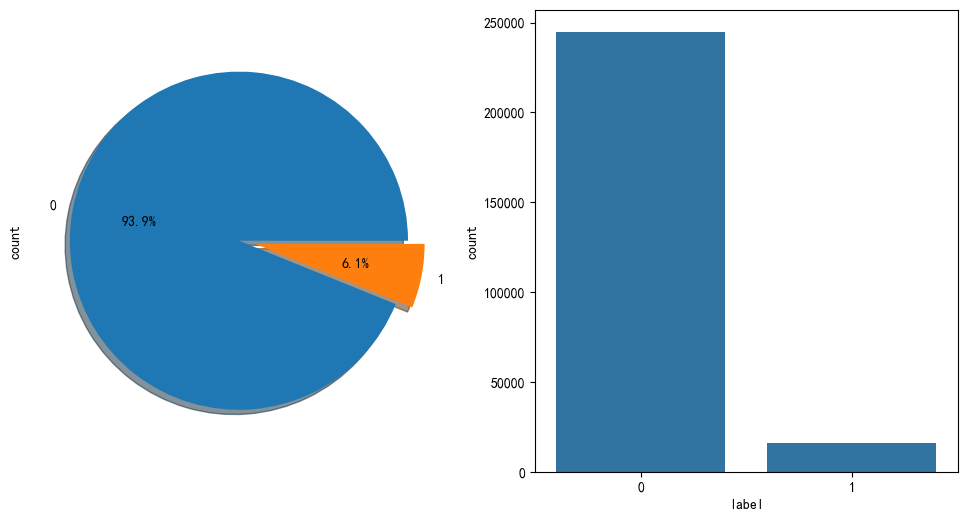

In [67]:
# 假设这里train_data是已经正确定义好的数据框
label_gp = train_data.groupby('label')['user_id'].count()
print('正负样本的数量：\n', label_gp)

_, axe = plt.subplots(1, 2, figsize=(12, 6))

train_data.label.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, explode=[0, 0.1], ax=axe[0])

# 通过data参数明确指定数据来源
sns.countplot(data=train_data, x='label', ax=axe[1])
plt.show()

选取top5店铺
店铺	购买次数
merchant_id
4044    3379
3828    3254
4173    2542
1102    2483
4976    1925
Name: count, dtype: int64


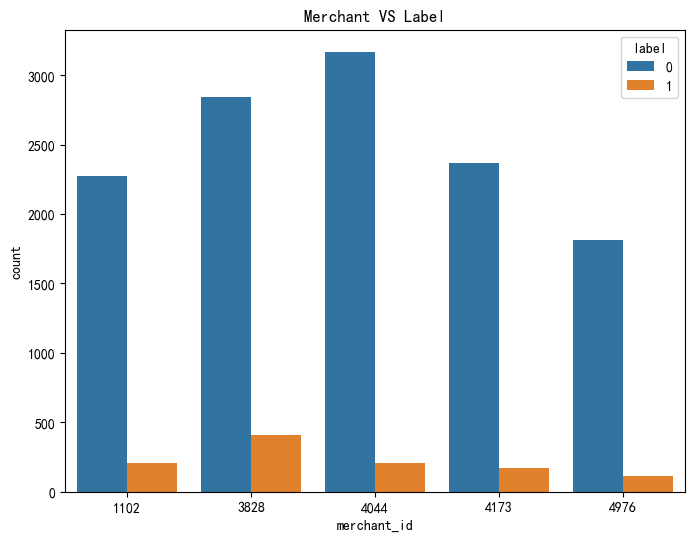

In [68]:
print('选取top5店铺\n店铺\t购买次数')
print(train_data.merchant_id.value_counts().head(5))
train_data_merchant = train_data.copy()
train_data_merchant['TOP5'] = train_data_merchant['merchant_id'].map(lambda x: 1 if x in [4044,3828,4173,1102,4976] else 0)
train_data_merchant = train_data_merchant[train_data_merchant['TOP5']==1]
plt.figure(figsize=(8,6))
plt.title('Merchant VS Label')
ax = sns.countplot(x='merchant_id', hue='label', data=train_data_merchant)  # 修改这里
for p in ax.patches:
    height = p.get_height()

In [69]:
all_data_1 = user_log.merge(train_data,on=['user_id'],how='left')

In [70]:
all_data_1[all_data_1['label'].notnull()].head()

user_id  item_id  cat_id  seller_id  brand_id time_stamp  action_type  \
419   234512   146770    1173        693    3186.0      06-25            0   
420   234512   146770    1173        693    3186.0      06-25            0   
421   234512  1106076     992       3783    8165.0      10-16            0   
422   234512  1106076     992       3783    8165.0      10-16            0   
423   234512   866567    1198        693    3186.0      06-25            0   

     merchant_id  label  
419       3018.0    0.0  
420       3271.0    0.0  
421       3018.0    0.0  
422       3271.0    0.0  
423       3018.0    0.0

In [71]:
all_data_2=all_data_1[all_data_1['label'].notnull()]


In [72]:
all_data_2_sum=all_data_2.groupby(['time_stamp'])['label'].sum().reset_index()
all_data_2_sum.head()

time_stamp   label
0      05-11   943.0
1      05-12   975.0
2      05-13  1221.0
3      05-14  1170.0
4      05-15  1260.0

In [73]:
all_data_2_sum['time_stamp'] = all_data_2_sum['time_stamp'].astype(str)
all_data_2_sum['label'] = all_data_2_sum['label'].astype(int)

In [74]:
a=[]
for i in range(len(all_data_2_sum)):
    if len(all_data_2_sum['time_stamp'][i])==3:
        a.append(all_data_2_sum['time_stamp'][i][0])
    else:
        a.append(all_data_2_sum['time_stamp'][i][0:2])

In [75]:
#all_data_2_sum['month']=a
#all_data_2_sum=all_data_2_sum.astype(int)

In [76]:
c=all_data_2_sum.groupby(['month'])['label'].sum().reset_index()
plt.plot(c['month'], c['label'], linewidth=1, color="orange", marker="o",label="Mean value")

KeyError: 'month'

特征工程

In [77]:
# 检查 'prob' 列是否存在
if 'prob' in test_data.columns:
    del test_data['prob']

train_data['target'] = 1
test_data['target'] = -1

# 使用 pd.concat 替代 append
all_data = pd.concat([train_data, test_data], ignore_index=True)

all_data = all_data.merge(user_info, on=['user_id'], how='left')
del train_data, test_data, user_info
gc.collect()

936

In [78]:
all_data.head()

user_id  merchant_id  label  target  age_range  gender
0    34176         3906    0.0       1        6.0     0.0
1    34176          121    0.0       1        6.0     0.0
2    34176         4356    1.0       1        6.0     0.0
3    34176         2217    0.0       1        6.0     0.0
4   230784         4818    0.0       1        0.0     0.0

In [79]:
all_data.dropna(subset=['age_range','gender'],inplace=True)

In [80]:
all_data.isnull().sum()

user_id             0
merchant_id         0
label          257626
target              0
age_range           0
gender              0
dtype: int64

In [81]:
# 用户店铺数
sell= user_log.groupby(['user_id'])['seller_id'].count().reset_index()

all_data = all_data.merge(sell,on=['user_id'],how='inner')
all_data.rename(columns={'seller_id':'sell_sum'},inplace=True)
all_data.head()

user_id  merchant_id  label  target  age_range  gender  sell_sum
0    34176         3906    0.0       1        6.0     0.0       451
1    34176          121    0.0       1        6.0     0.0       451
2    34176         4356    1.0       1        6.0     0.0       451
3    34176         2217    0.0       1        6.0     0.0       451
4   230784         4818    0.0       1        0.0     0.0        54

In [82]:
def nunique_k(data,sigle_name,new_name_1):
    data1=user_log.groupby(['user_id'])[sigle_name].nunique().reset_index()
    
    data_union=data.merge(data1,on=['user_id'],how='inner')
    data_union.rename(columns={sigle_name:new_name_1},inplace=True)
    return data_union
    

In [83]:
# 不同店铺个数
all_data=nunique_k(all_data,'seller_id','seller_id_unique')

In [84]:
# 不同品类个数
all_data=nunique_k(all_data,'cat_id','cat_id_unique')

In [85]:
# 不同品牌个数
all_data=nunique_k(all_data,'brand_id','brand_id_unique')

In [86]:
# 不同商品个数
all_data=nunique_k(all_data,'item_id','item_id_unique')

In [87]:
# 活跃天数
all_data=nunique_k(all_data,'time_stamp','time_stamp_unique')

In [88]:
# 不用行为种数
all_data=nunique_k(all_data,'action_type','action_type_unique')

In [89]:
all_data.head()

user_id  merchant_id  label  target  age_range  gender  sell_sum  \
0    34176         3906    0.0       1        6.0     0.0       451   
1    34176          121    0.0       1        6.0     0.0       451   
2    34176         4356    1.0       1        6.0     0.0       451   
3    34176         2217    0.0       1        6.0     0.0       451   
4   230784         4818    0.0       1        0.0     0.0        54   

   seller_id_unique  cat_id_unique  brand_id_unique  item_id_unique  \
0               109             45              108             256   
1               109             45              108             256   
2               109             45              108             256   
3               109             45              108             256   
4                20             17               19              31   

   time_stamp_unique  action_type_unique  
0                 47                   3  
1                 47                   3  
2                 47                   3  
3                 47                   3  
4                 16                   2

In [90]:
user_log.head()

user_id  item_id  cat_id  seller_id  brand_id time_stamp  action_type
0   328862   323294     833       2882    2661.0      08-29            0
1   328862   844400    1271       2882    2661.0      08-29            0
2   328862   575153    1271       2882    2661.0      08-29            0
3   328862   996875    1271       2882    2661.0      08-29            0
4   328862  1086186    1271       1253    1049.0      08-29            0

In [92]:
''' a=[1,2,4,5,6,4,6,8,9,1,1,2,5,9]
 b=Counter(a)
 print(b)
 print(b.most_common(1)[0][1])'''

' a=[1,2,4,5,6,4,6,8,9,1,1,2,5,9]\n b=Counter(a)\n print(b)\n print(b.most_common(1)[0][1])'

In [93]:
def most_love(data_1,most_name,new_name_2):
    data2=user_log.groupby(['user_id'])[most_name].apply(lambda x: Counter(x).most_common(1)[0][0]).reset_index()
    data_union_1=data_1.merge(data2,on=['user_id'],how='inner')
    data_union_1.rename(columns={most_name:new_name_2},inplace=True)
    return data_union_1

In [94]:
# 用户最喜欢的店铺
all_data=most_love(all_data,'seller_id','sell_id_most')
# 最喜欢的类目
all_data=most_love(all_data,'cat_id','cat_id_most')
# 最喜欢的品牌
all_data=most_love(all_data,'brand_id','brand_id_most')
# 最常见的行为动作
all_data=most_love(all_data,'action_type','action_type_most')

In [95]:
all_data.head()

user_id  merchant_id  label  target  age_range  gender  sell_sum  \
0    34176         3906    0.0       1        6.0     0.0       451   
1    34176          121    0.0       1        6.0     0.0       451   
2    34176         4356    1.0       1        6.0     0.0       451   
3    34176         2217    0.0       1        6.0     0.0       451   
4   230784         4818    0.0       1        0.0     0.0        54   

   seller_id_unique  cat_id_unique  brand_id_unique  item_id_unique  \
0               109             45              108             256   
1               109             45              108             256   
2               109             45              108             256   
3               109             45              108             256   
4                20             17               19              31   

   time_stamp_unique  action_type_unique  sell_id_most  cat_id_most  \
0                 47                   3           331          662   
1                 47                   3           331          662   
2                 47                   3           331          662   
3                 47                   3           331          662   
4                 16                   2          3556          407   

   brand_id_most  action_type_most  
0         4094.0                 0  
1         4094.0                 0  
2         4094.0                 0  
3         4094.0                 0  
4         1236.0                 0

In [96]:
def most_love_cnt(data_1,most_name,new_name_2):
    data2=user_log.groupby(['user_id'])[most_name].apply(lambda x: Counter(x).most_common(1)[0][1]).reset_index()
    data_union_1=data_1.merge(data2,on=['user_id'],how='inner')
    data_union_1.rename(columns={most_name:new_name_2},inplace=True)
    return data_union_1
# 用户最喜欢店铺的购买次数
all_data=most_love_cnt(all_data,'seller_id','sell_id_most_cnt')
# 用户最喜欢类目的购买次数
all_data=most_love_cnt(all_data,'cat_id','cat_id_most_cnt')
# 用户最喜欢品牌的购买次数
all_data=most_love_cnt(all_data,'brand_id','brand_id_most_cnt')
# 最常见的行为动作 行为次数
all_data=most_love_cnt(all_data,'action_type','action_type_most_cnt')

In [98]:
all_data.head()

user_id  merchant_id  label  target  age_range  gender  sell_sum  \
0    34176         3906    0.0       1        6.0     0.0       451   
1    34176          121    0.0       1        6.0     0.0       451   
2    34176         4356    1.0       1        6.0     0.0       451   
3    34176         2217    0.0       1        6.0     0.0       451   
4   230784         4818    0.0       1        0.0     0.0        54   

   seller_id_unique  cat_id_unique  brand_id_unique  ...  time_stamp_unique  \
0               109             45              108  ...                 47   
1               109             45              108  ...                 47   
2               109             45              108  ...                 47   
3               109             45              108  ...                 47   
4                20             17               19  ...                 16   

   action_type_unique  sell_id_most  cat_id_most  brand_id_most  \
0                   3           331          662         4094.0   
1                   3           331          662         4094.0   
2                   3           331          662         4094.0   
3                   3           331          662         4094.0   
4                   2          3556          407         1236.0   

   action_type_most  sell_id_most_cnt  cat_id_most_cnt  brand_id_most_cnt  \
0                 0                70               98                 70   
1                 0                70               98                 70   
2                 0                70               98                 70   
3                 0                70               98                 70   
4                 0                10                9                 10   

   action_type_most_cnt  
0                   410  
1                   410  
2                   410  
3                   410  
4                    47  

[5 rows x 21 columns]

In [99]:
user_id_union=list(set(all_data['user_id']))

In [100]:
def action_type_select(data,num,new_name):
    d=user_log.groupby(['user_id'])['action_type'].apply(lambda x: Counter(x))
    e=dict(d)
    k=[]
    for i in user_id_union:
        try: 
            k.append(e[(i,num)])
        except KeyError:
            k.append(0) 
    data3=pd.DataFrame({'user_id':user_id_union,new_name:k})
    data_union_2=data.merge(data3,on=['user_id'],how='inner')
    return data_union_2


In [101]:
# 点击次数
all_data=action_type_select(all_data,0,'action_type_sum_0')
# 加购次数
all_data=action_type_select(all_data,1,'action_type_sum_1')
# 购买次数
all_data=action_type_select(all_data,2,'action_type_sum_2')
# 收藏次数
all_data=action_type_select(all_data,3,'action_type_sum_2')

In [102]:
'''all_data=all_data.T.drop_duplicates(keep='first').T'''

"all_data=all_data.T.drop_duplicates(keep='first').T"

In [103]:
all_data.head()

user_id  merchant_id  label  target  age_range  gender  sell_sum  \
0    34176         3906    0.0       1        6.0     0.0       451   
1    34176          121    0.0       1        6.0     0.0       451   
2    34176         4356    1.0       1        6.0     0.0       451   
3    34176         2217    0.0       1        6.0     0.0       451   
4   230784         4818    0.0       1        0.0     0.0        54   

   seller_id_unique  cat_id_unique  brand_id_unique  ...  brand_id_most  \
0               109             45              108  ...         4094.0   
1               109             45              108  ...         4094.0   
2               109             45              108  ...         4094.0   
3               109             45              108  ...         4094.0   
4                20             17               19  ...         1236.0   

   action_type_most  sell_id_most_cnt  cat_id_most_cnt  brand_id_most_cnt  \
0                 0                70               98                 70   
1                 0                70               98                 70   
2                 0                70               98                 70   
3                 0                70               98                 70   
4                 0                10                9                 10   

   action_type_most_cnt  action_type_sum_0  action_type_sum_1  \
0                   410              410.0                NaN   
1                   410              410.0                NaN   
2                   410              410.0                NaN   
3                   410              410.0                NaN   
4                    47               47.0                NaN   

   action_type_sum_2_x  action_type_sum_2_y  
0                 34.0                  7.0  
1                 34.0                  7.0  
2                 34.0                  7.0  
3                 34.0                  7.0  
4                  7.0                  NaN  

[5 rows x 25 columns]

In [104]:
train = all_data[all_data['target'] == 1].reset_index(drop = True)
test = all_data[all_data['target'] == -1].reset_index(drop = True)

In [105]:
train.drop(['target'],axis=1,inplace=True)
test.drop(['target'],axis=1,inplace=True)

In [106]:
train.fillna(0,inplace=True)

In [107]:
test.drop(['label'],axis=1,inplace=True)

In [108]:
test.fillna(0,inplace=True)

In [109]:
test.head()

user_id  merchant_id  age_range  gender  sell_sum  seller_id_unique  \
0   163968         4605        0.0     0.0        81                21   
1   360576         1581        2.0     2.0        77                37   
2    98688         1964        6.0     0.0        56                22   
3    98688         3645        6.0     0.0        56                22   
4   295296         3361        2.0     1.0       176                56   

   cat_id_unique  brand_id_unique  item_id_unique  time_stamp_unique  ...  \
0             21               22              34                 26  ...   
1             27               37              65                 22  ...   
2             18               21              25                 10  ...   
3             18               21              25                 10  ...   
4             32               47              85                 33  ...   

   brand_id_most  action_type_most  sell_id_most_cnt  cat_id_most_cnt  \
0         7178.0                 0                22               17   
1         4066.0                 0                10               13   
2         3637.0                 0                11               11   
3         3637.0                 0                11               11   
4          487.0                 0                50               59   

   brand_id_most_cnt  action_type_most_cnt  action_type_sum_0  \
0                 22                    63               63.0   
1                 10                    71               71.0   
2                 11                    51               51.0   
3                 11                    51               51.0   
4                 49                   162              162.0   

   action_type_sum_1  action_type_sum_2_x  action_type_sum_2_y  
0                0.0                 16.0                  2.0  
1                0.0                  6.0                  0.0  
2                0.0                  5.0                  0.0  
3                0.0                  5.0                  0.0  
4                0.0                  7.0                  7.0  

[5 rows x 23 columns]

In [110]:
train.to_csv('train_all_k.csv',header=True,index=False)
test.to_csv('test_all_k.csv',header=True,index=False)

In [111]:
pd.read_csv('train_all_k.csv').head()

user_id  merchant_id  label  age_range  gender  sell_sum  seller_id_unique  \
0    34176         3906    0.0        6.0     0.0       451               109   
1    34176          121    0.0        6.0     0.0       451               109   
2    34176         4356    1.0        6.0     0.0       451               109   
3    34176         2217    0.0        6.0     0.0       451               109   
4   230784         4818    0.0        0.0     0.0        54                20   

   cat_id_unique  brand_id_unique  item_id_unique  ...  brand_id_most  \
0             45              108             256  ...         4094.0   
1             45              108             256  ...         4094.0   
2             45              108             256  ...         4094.0   
3             45              108             256  ...         4094.0   
4             17               19              31  ...         1236.0   

   action_type_most  sell_id_most_cnt  cat_id_most_cnt  brand_id_most_cnt  \
0                 0                70               98                 70   
1                 0                70               98                 70   
2                 0                70               98                 70   
3                 0                70               98                 70   
4                 0                10                9                 10   

   action_type_most_cnt  action_type_sum_0  action_type_sum_1  \
0                   410              410.0                0.0   
1                   410              410.0                0.0   
2                   410              410.0                0.0   
3                   410              410.0                0.0   
4                    47               47.0                0.0   

   action_type_sum_2_x  action_type_sum_2_y  
0                 34.0                  7.0  
1                 34.0                  7.0  
2                 34.0                  7.0  
3                 34.0                  7.0  
4                  7.0                  0.0  

[5 rows x 24 columns]

建模

In [112]:
train_data=pd.read_csv('train_all_k.csv')
train_data.head()

user_id  merchant_id  label  age_range  gender  sell_sum  seller_id_unique  \
0    34176         3906    0.0        6.0     0.0       451               109   
1    34176          121    0.0        6.0     0.0       451               109   
2    34176         4356    1.0        6.0     0.0       451               109   
3    34176         2217    0.0        6.0     0.0       451               109   
4   230784         4818    0.0        0.0     0.0        54                20   

   cat_id_unique  brand_id_unique  item_id_unique  ...  brand_id_most  \
0             45              108             256  ...         4094.0   
1             45              108             256  ...         4094.0   
2             45              108             256  ...         4094.0   
3             45              108             256  ...         4094.0   
4             17               19              31  ...         1236.0   

   action_type_most  sell_id_most_cnt  cat_id_most_cnt  brand_id_most_cnt  \
0                 0                70               98                 70   
1                 0                70               98                 70   
2                 0                70               98                 70   
3                 0                70               98                 70   
4                 0                10                9                 10   

   action_type_most_cnt  action_type_sum_0  action_type_sum_1  \
0                   410              410.0                0.0   
1                   410              410.0                0.0   
2                   410              410.0                0.0   
3                   410              410.0                0.0   
4                    47               47.0                0.0   

   action_type_sum_2_x  action_type_sum_2_y  
0                 34.0                  7.0  
1                 34.0                  7.0  
2                 34.0                  7.0  
3                 34.0                  7.0  
4                  7.0                  0.0  

[5 rows x 24 columns]

In [113]:
test_data=pd.read_csv('test_all_k.csv')
test_data.head()

user_id  merchant_id  age_range  gender  sell_sum  seller_id_unique  \
0   163968         4605        0.0     0.0        81                21   
1   360576         1581        2.0     2.0        77                37   
2    98688         1964        6.0     0.0        56                22   
3    98688         3645        6.0     0.0        56                22   
4   295296         3361        2.0     1.0       176                56   

   cat_id_unique  brand_id_unique  item_id_unique  time_stamp_unique  ...  \
0             21               22              34                 26  ...   
1             27               37              65                 22  ...   
2             18               21              25                 10  ...   
3             18               21              25                 10  ...   
4             32               47              85                 33  ...   

   brand_id_most  action_type_most  sell_id_most_cnt  cat_id_most_cnt  \
0         7178.0                 0                22               17   
1         4066.0                 0                10               13   
2         3637.0                 0                11               11   
3         3637.0                 0                11               11   
4          487.0                 0                50               59   

   brand_id_most_cnt  action_type_most_cnt  action_type_sum_0  \
0                 22                    63               63.0   
1                 10                    71               71.0   
2                 11                    51               51.0   
3                 11                    51               51.0   
4                 49                   162              162.0   

   action_type_sum_1  action_type_sum_2_x  action_type_sum_2_y  
0                0.0                 16.0                  2.0  
1                0.0                  6.0                  0.0  
2                0.0                  5.0                  0.0  
3                0.0                  5.0                  0.0  
4                0.0                  7.0                  7.0  

[5 rows x 23 columns]

In [114]:
train_data['label'].value_counts()

label
0.0    241303
1.0     15838
Name: count, dtype: int64

train_data_1是train_data处理后的训练数据集，后面对模型进行测试的时候是将train_data_1进行划分成训练集和测试集，和test_data_1无关

In [115]:
features_columns = [col for col in train_data.columns if col not in ['user_id','label']]
train_data_1 = train_data[features_columns]
test_data_1 = test_data[features_columns]
target =train_data['label']

target.head
train_data.head

<bound method NDFrame.head of         user_id  merchant_id  label  age_range  gender  sell_sum  \
0         34176         3906    0.0        6.0     0.0       451   
1         34176          121    0.0        6.0     0.0       451   
2         34176         4356    1.0        6.0     0.0       451   
3         34176         2217    0.0        6.0     0.0       451   
4        230784         4818    0.0        0.0     0.0        54   
...         ...          ...    ...        ...     ...       ...   
257136   359807         4325    0.0        4.0     1.0       117   
257137   294527         3971    0.0        0.0     1.0       198   
257138   294527          152    0.0        0.0     1.0       198   
257139   294527         2537    0.0        0.0     1.0       198   
257140   229247         4140    0.0        4.0     2.0       194   

        seller_id_unique  cat_id_unique  brand_id_unique  item_id_unique  ...  \
0                    109             45              108             256

In [116]:

from sklearn.linear_model import LogisticRegression#逻辑回归
from sklearn.neighbors import KNeighborsClassifier#KNN
from sklearn.naive_bayes import GaussianNB#朴素贝叶斯
from sklearn.tree import DecisionTreeClassifier#决策树
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier#随机森林   AdaBoost

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold


In [117]:
def model_clf(model):
    model.fit(X_train, y_train)
    y_train_pred = model.predict_proba(X_train)
    y_train_pred_pos = y_train_pred[:,1]

    y_test_pred = model.predict_proba(X_test)
    y_test_pred_pos = y_test_pred[:,1]

    auc_train = roc_auc_score(y_train, y_train_pred_pos)#AUC评分
    auc_test = roc_auc_score(y_test, y_test_pred_pos)

    print(f"Train AUC Score {auc_train}")
    print(f"Test AUC Score {auc_test}")

    fpr, tpr, _ = roc_curve(y_test,y_test_pred_pos)#绘制ROC曲线
    return fpr,tpr

逻辑斯蒂回归

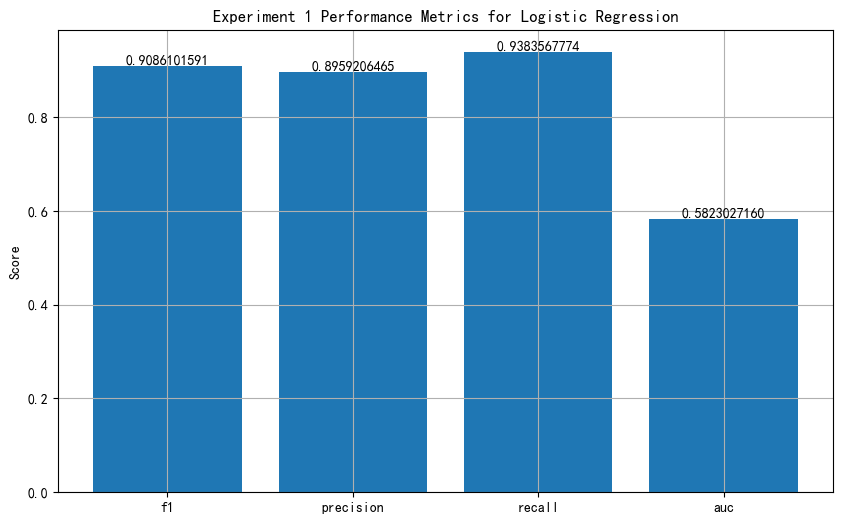

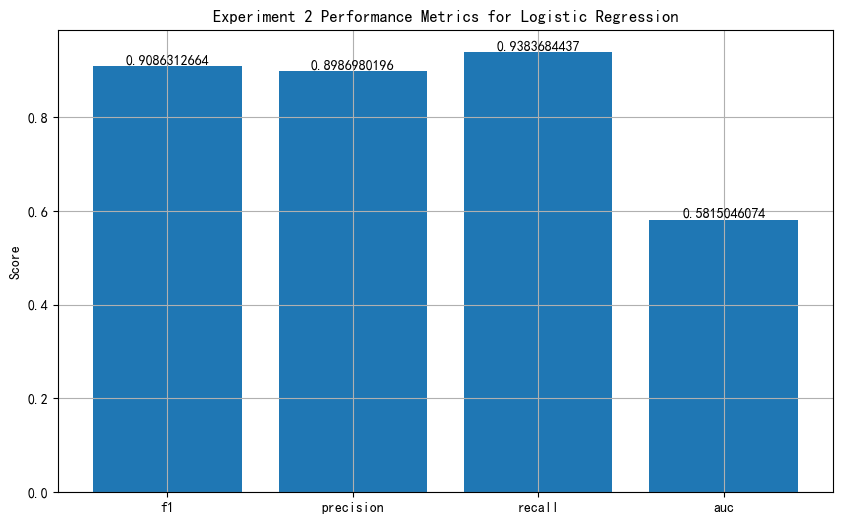

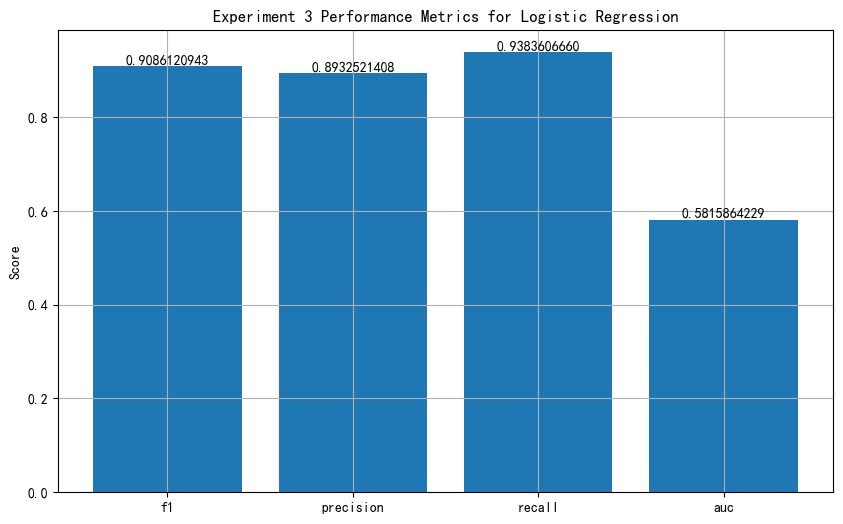

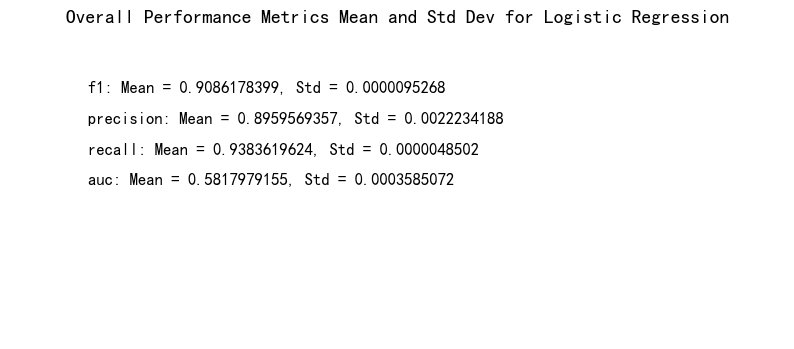

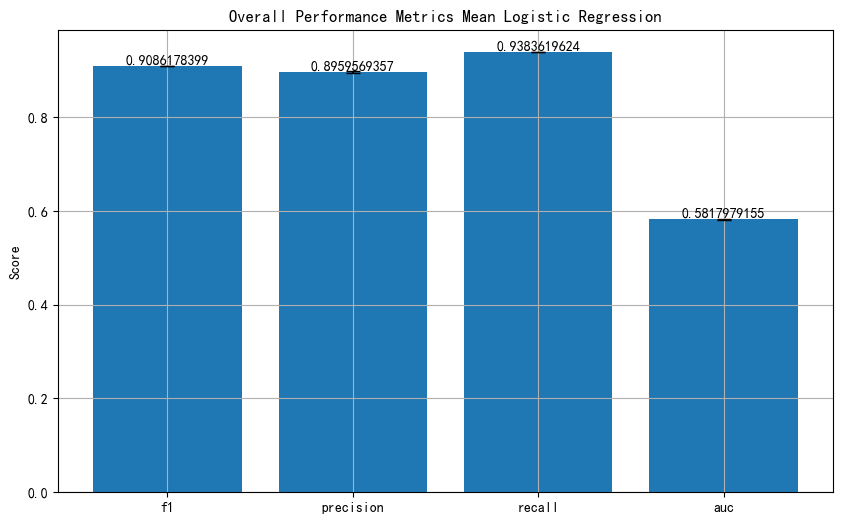

In [118]:


# 假设 train_data_1 和 target 已经定义
stdScaler = StandardScaler()
X = stdScaler.fit_transform(train_data_1)
y = target

# 定义逻辑斯蒂回归模型
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

# 进行三次实验
num_experiments = 3
all_scores = []

for exp_num in range(num_experiments):
    # 使用五折交叉验证
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=exp_num)
    f1_scores, precision_scores, recall_scores, accuracy_scores, auc_scores = [], [], [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test)
        y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

        f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        precision_scores.append(precision_score(y_test, y_test_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_test_pred, average='weighted'))
        #accuracy_scores.append(accuracy_score(y_test, y_test_pred))
        auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))

    # 记录每次实验的平均分数
    scores = {
        'f1': np.mean(f1_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        #'accuracy': np.mean(accuracy_scores),
        'auc': np.mean(auc_scores)
    }
    all_scores.append(scores)

    # 绘制每次实验的结果
    plt.figure(figsize=(10, 6))
    metrics = list(scores.keys())
    values = list(scores.values())
    plt.bar(metrics, values, capsize=5)
    for i, value in enumerate(values):
        plt.text(i, value, f'{value:.10f}', ha='center', va='bottom')
    plt.title(f'Experiment {exp_num + 1} Performance Metrics for Logistic Regression')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

# 计算三次实验的均值和标准差
metrics = ['f1', 'precision', 'recall', 'auc']
means = {metric: np.mean([scores[metric] for scores in all_scores]) for metric in metrics}
stds = {metric: np.std([scores[metric] for scores in all_scores]) for metric in metrics}

# 创建一个空白图像
plt.figure(figsize=(10, 4))
plt.axis('off')  # 关闭坐标轴

# 在图像上添加文本
text_y_position = 0.8  # 初始文本的y位置
for metric in metrics:
    text = f"{metric}: Mean = {means[metric]:.10f}, Std = {stds[metric]:.10f}"
    plt.text(0.1, text_y_position, text, fontsize=12, ha='left')
    text_y_position -= 0.1  # 每行文本向下移动

plt.title('Overall Performance Metrics Mean and Std Dev for Logistic Regression', fontsize=14)
plt.show()

# 绘制均值和标准差
plt.figure(figsize=(10, 6))
plt.bar(metrics, [means[metric] for metric in metrics], yerr=[stds[metric] for metric in metrics], capsize=5)
for i, metric in enumerate(metrics):
    plt.text(i, means[metric], f'{means[metric]:.10f}', ha='center', va='bottom')
plt.title('Overall Performance Metrics Mean Logistic Regression')
plt.ylabel('Score')
plt.grid(True)
plt.show()

knn 模型

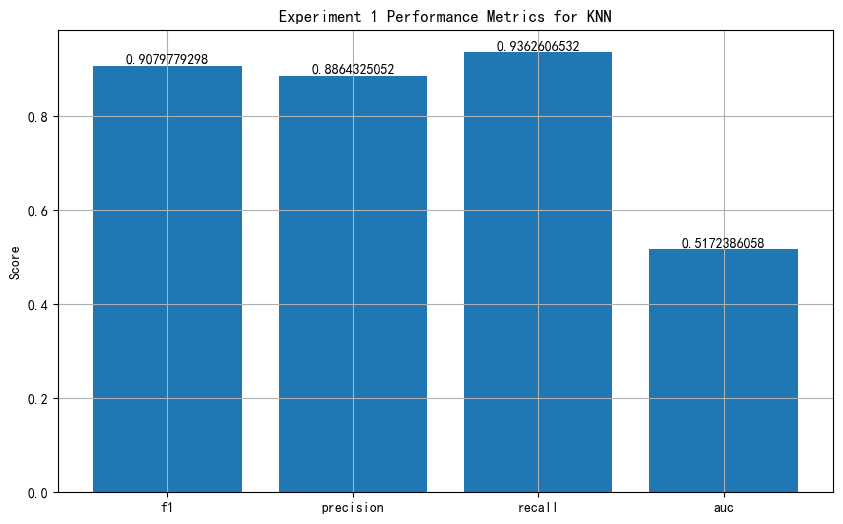

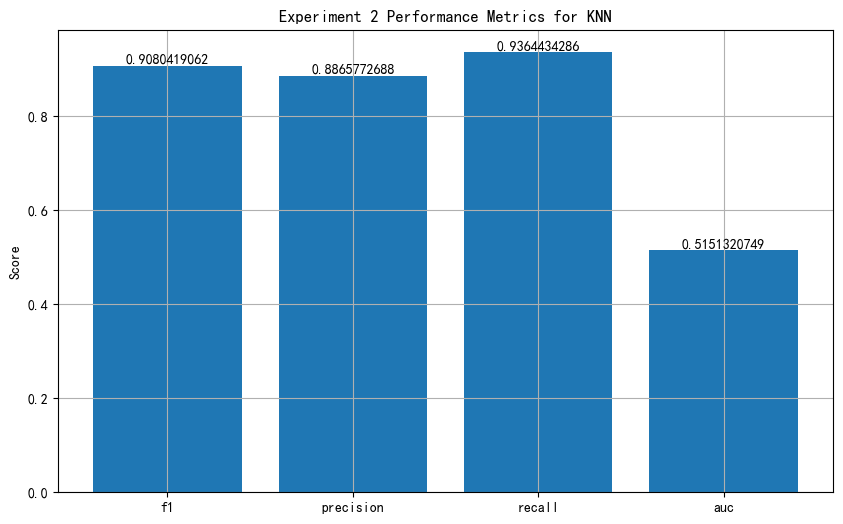

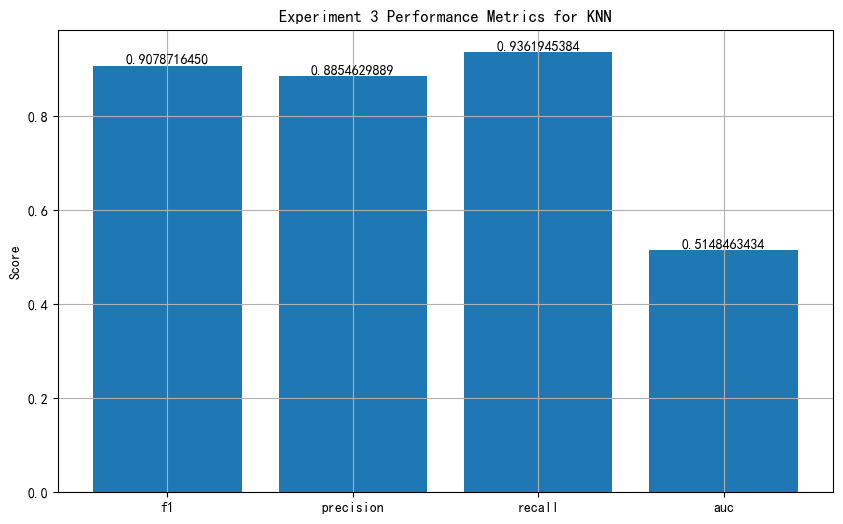

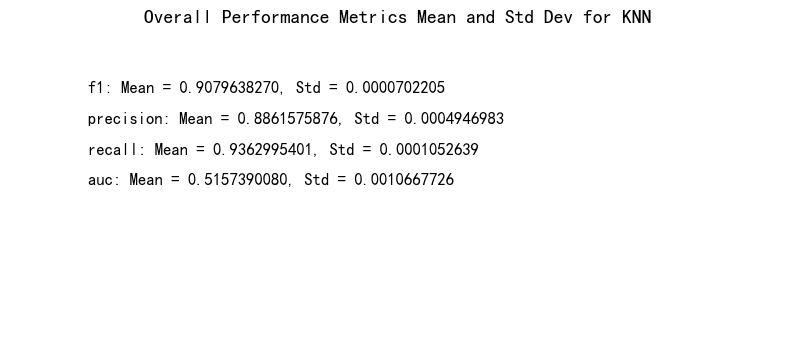

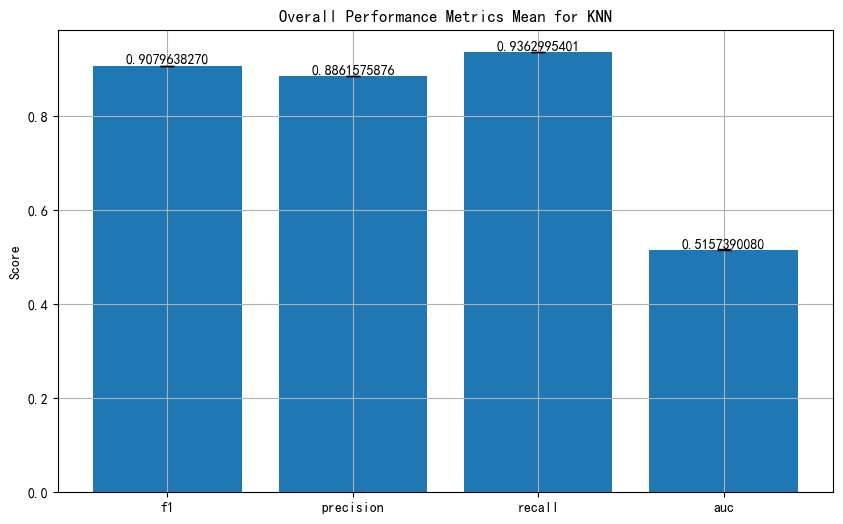

In [119]:

# 假设 train_data_1 和 target 已经定义
stdScaler = StandardScaler()
X = stdScaler.fit_transform(train_data_1)
y = target

# 定义KNN模型
clf = KNeighborsClassifier(n_neighbors=5)

# 进行三次实验
num_experiments = 3
all_scores = []

for exp_num in range(num_experiments):
    # 使用五折交叉验证
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=exp_num)
    f1_scores, precision_scores, recall_scores, accuracy_scores, auc_scores = [], [], [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test)
        y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

        f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        precision_scores.append(precision_score(y_test, y_test_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_test_pred, average='weighted'))
        #accuracy_scores.append(accuracy_score(y_test, y_test_pred))
        auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))

    # 记录每次实验的平均分数
    scores = {
        'f1': np.mean(f1_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        #'accuracy': np.mean(accuracy_scores),
        'auc': np.mean(auc_scores)
    }
    all_scores.append(scores)

    # 绘制每次实验的结果
    plt.figure(figsize=(10, 6))
    metrics = list(scores.keys())
    values = list(scores.values())
    plt.bar(metrics, values, capsize=5)
    for i, value in enumerate(values):
        plt.text(i, value, f'{value:.10f}', ha='center', va='bottom')
    plt.title(f'Experiment {exp_num + 1} Performance Metrics for KNN')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

# 计算三次实验的均值和标准差
metrics = ['f1', 'precision', 'recall','auc']
means = {metric: np.mean([scores[metric] for scores in all_scores]) for metric in metrics}
stds = {metric: np.std([scores[metric] for scores in all_scores]) for metric in metrics}

# 创建一个空白图像
plt.figure(figsize=(10, 4))
plt.axis('off')  # 关闭坐标轴

# 在图像上添加文本
text_y_position = 0.8  # 初始文本的y位置
for metric in metrics:
    text = f"{metric}: Mean = {means[metric]:.10f}, Std = {stds[metric]:.10f}"
    plt.text(0.1, text_y_position, text, fontsize=12, ha='left')
    text_y_position -= 0.1  # 每行文本向下移动

plt.title('Overall Performance Metrics Mean and Std Dev for KNN', fontsize=14)
plt.show()

# 绘制均值和标准差
plt.figure(figsize=(10, 6))
plt.bar(metrics, [means[metric] for metric in metrics], yerr=[stds[metric] for metric in metrics], capsize=5)
for i, metric in enumerate(metrics):
    plt.text(i, means[metric], f'{means[metric]:.10f}', ha='center', va='bottom')
plt.title('Overall Performance Metrics Mean for KNN')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [75]:

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train_data_1)

#clf.fit(X_train, y_train)

# 对测试数据进行相同的标准化处理
test_data_scaled = stdScaler.transform(test_data_1)  # 假设 test_data_1 是测试数据的特征

# 对测试数据进行预测
pred = clf.predict_proba(test_data_scaled)

# 提取正类的概率
pred_list = [p[1] for p in pred]

# 创建 DataFrame 并保存到 CSV
df_out = pd.DataFrame()
df_out['user_id'] = test_data['user_id'].astype(int)
df_out['merchant_id'] = test_data['merchant_id'].astype(int)
df_out['predict_prob'] = pred_list
df_out.to_csv('knn_prediction.csv', index=0)

GaussianNB 模型

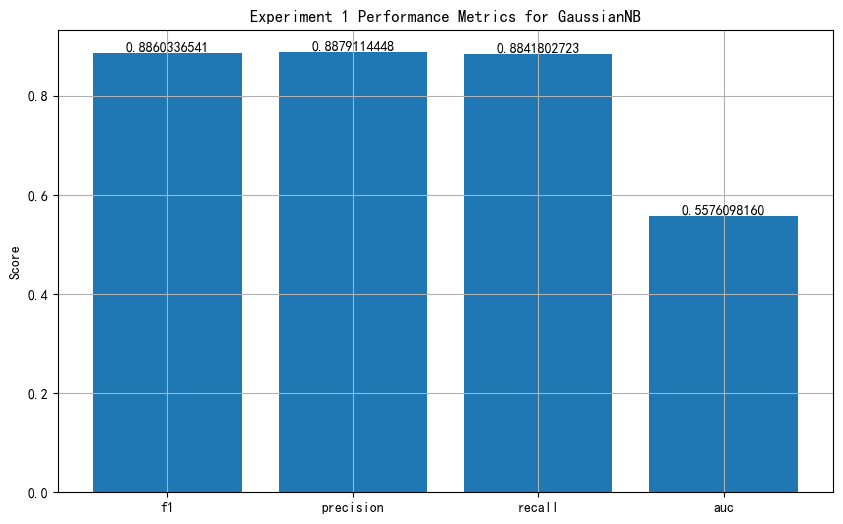

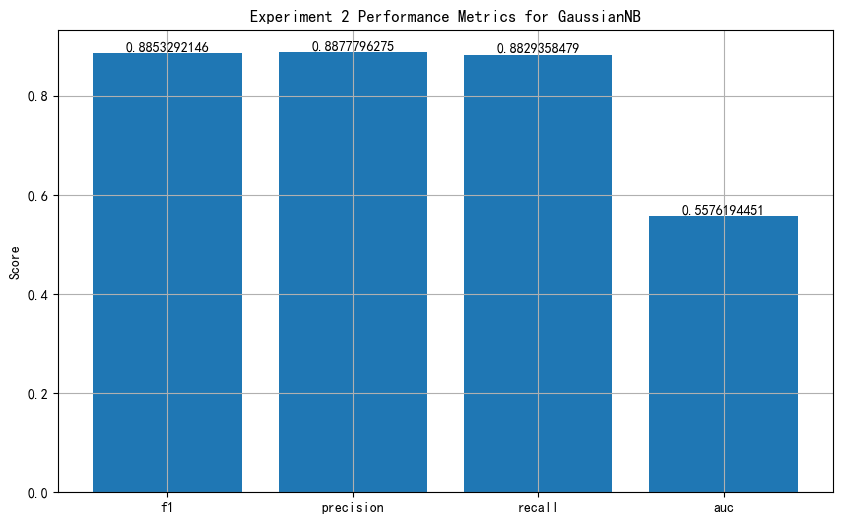

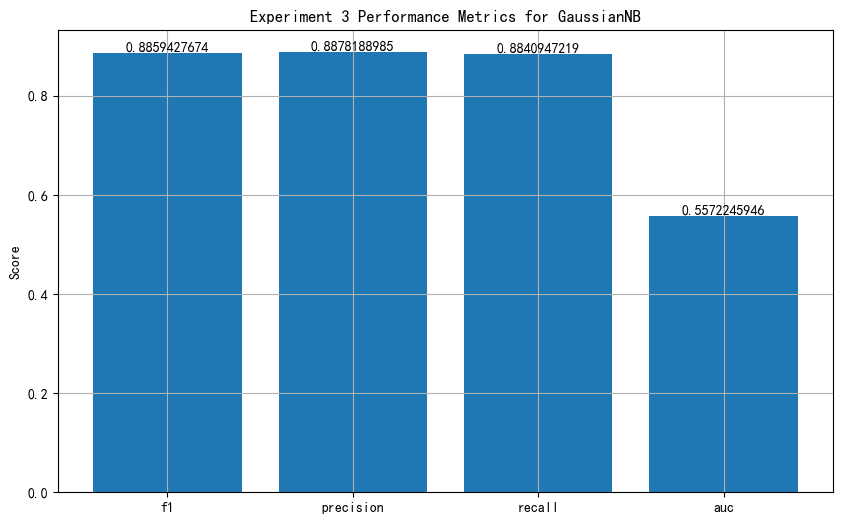

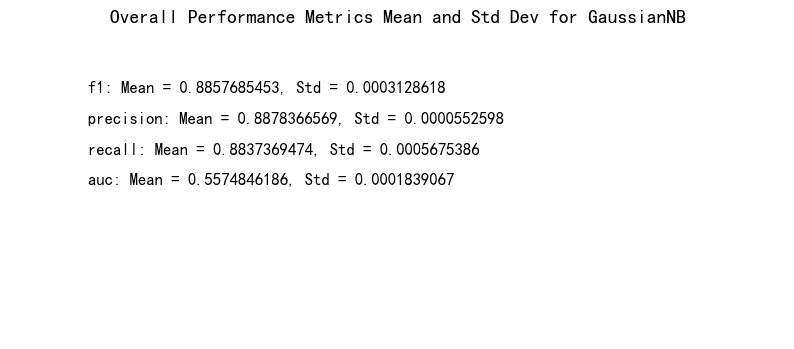

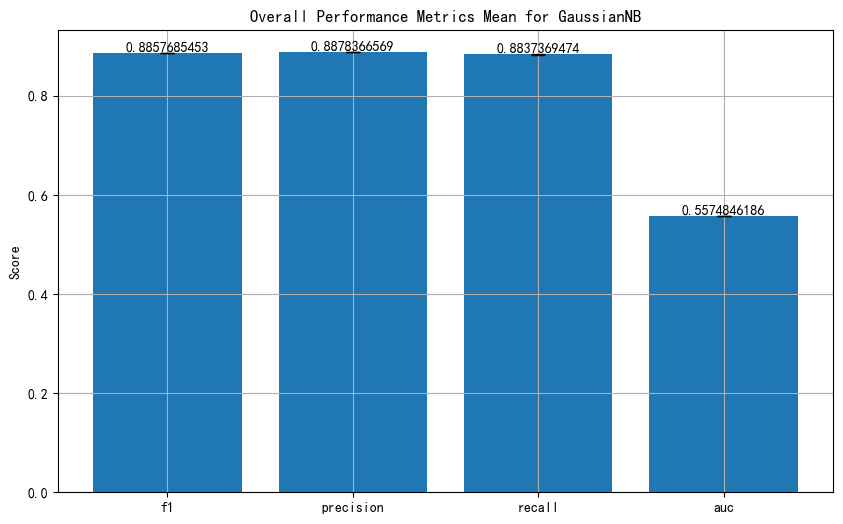

In [120]:

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train_data_1)
y = target

# 定义GaussianNB模型
clf = GaussianNB()

# 进行三次实验
num_experiments = 3
all_scores = []

for exp_num in range(num_experiments):
    # 使用五折交叉验证
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=exp_num)
    f1_scores, precision_scores, recall_scores, accuracy_scores, auc_scores = [], [], [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test)
        y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

        f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        precision_scores.append(precision_score(y_test, y_test_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_test_pred, average='weighted'))
        #accuracy_scores.append(accuracy_score(y_test, y_test_pred))
        auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))

    # 记录每次实验的平均分数
    scores = {
        'f1': np.mean(f1_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        #'accuracy': np.mean(accuracy_scores),
        'auc': np.mean(auc_scores)
    }
    all_scores.append(scores)

    # 绘制每次实验的结果
    plt.figure(figsize=(10, 6))
    metrics = list(scores.keys())
    values = list(scores.values())
    plt.bar(metrics, values, capsize=5)
    for i, value in enumerate(values):
        plt.text(i, value, f'{value:.10f}', ha='center', va='bottom')
    plt.title(f'Experiment {exp_num + 1} Performance Metrics for GaussianNB')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

# 计算三次实验的均值和标准差
metrics = ['f1', 'precision', 'recall','auc']
means = {metric: np.mean([scores[metric] for scores in all_scores]) for metric in metrics}
stds = {metric: np.std([scores[metric] for scores in all_scores]) for metric in metrics}

# 创建一个空白图像
plt.figure(figsize=(10, 4))
plt.axis('off')  # 关闭坐标轴

# 在图像上添加文本
text_y_position = 0.8  # 初始文本的y位置
for metric in metrics:
    text = f"{metric}: Mean = {means[metric]:.10f}, Std = {stds[metric]:.10f}"
    plt.text(0.1, text_y_position, text, fontsize=12, ha='left')
    text_y_position -= 0.1  # 每行文本向下移动

plt.title('Overall Performance Metrics Mean and Std Dev for GaussianNB', fontsize=14)
plt.show()

# 绘制均值和标准差
plt.figure(figsize=(10, 6))
plt.bar(metrics, [means[metric] for metric in metrics], yerr=[stds[metric] for metric in metrics], capsize=5)
for i, metric in enumerate(metrics):
    plt.text(i, means[metric], f'{means[metric]:.10f}', ha='center', va='bottom')
plt.title('Overall Performance Metrics Mean for GaussianNB')
plt.ylabel('Score')
plt.grid(True)
plt.show()

决策树模型

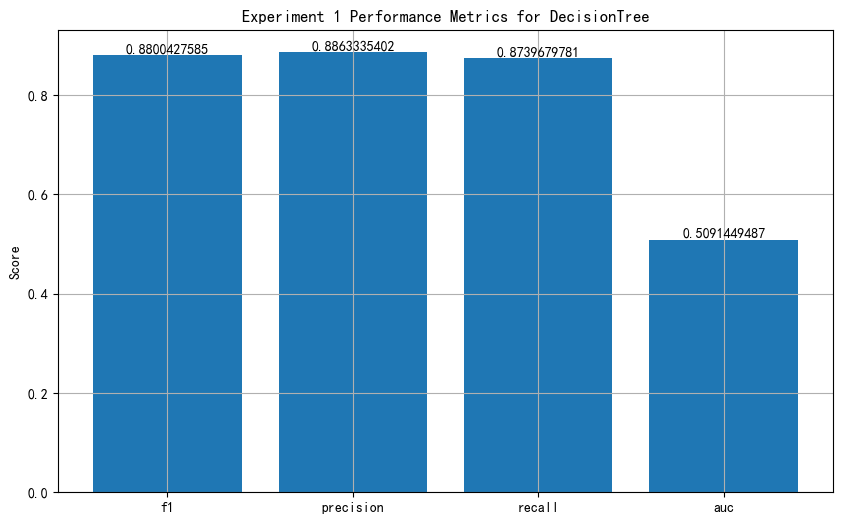

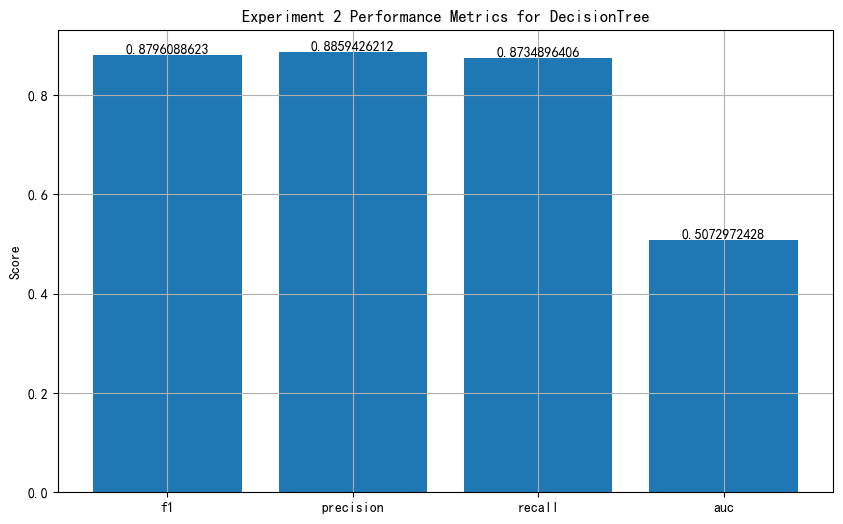

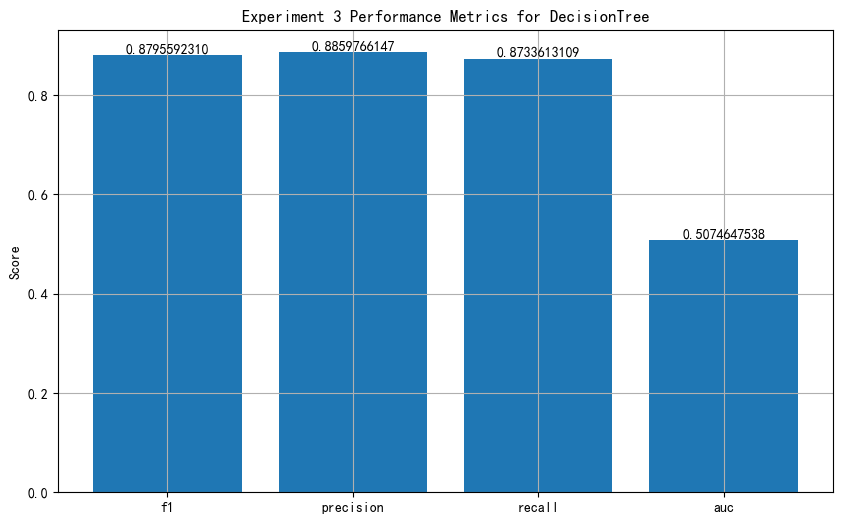

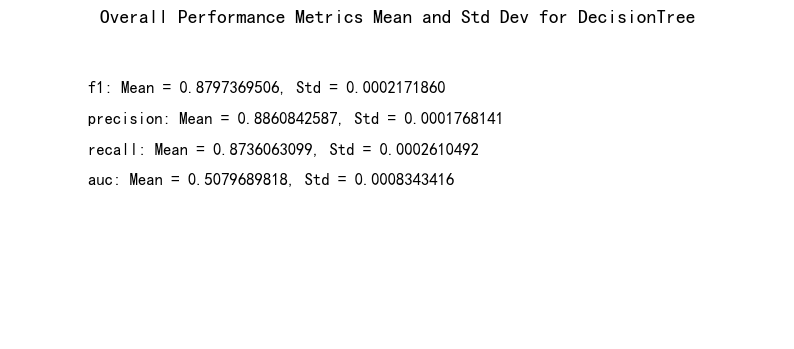

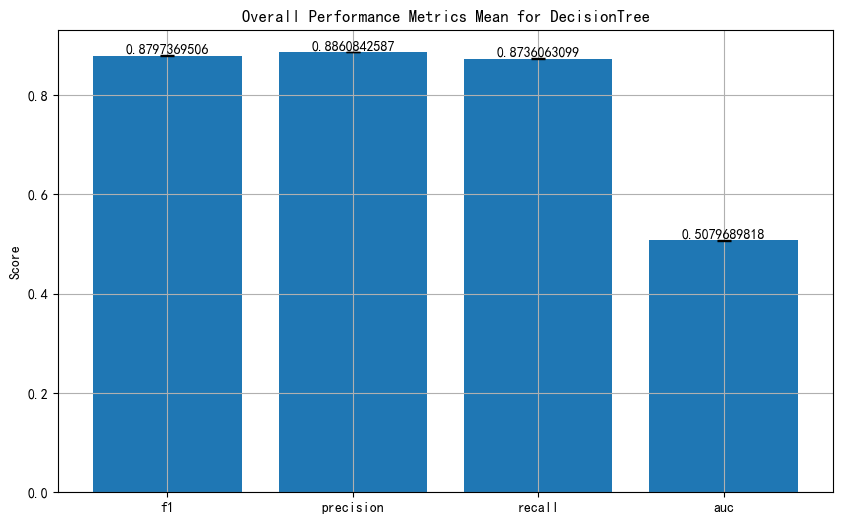

In [121]:

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train_data_1)
y = target

# 定义决策树模型
clf = DecisionTreeClassifier()

# 进行三次实验
num_experiments = 3
all_scores = []

for exp_num in range(num_experiments):
    # 使用五折交叉验证
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=exp_num)
    f1_scores, precision_scores, recall_scores, accuracy_scores, auc_scores = [], [], [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test)
        y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

        f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        precision_scores.append(precision_score(y_test, y_test_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_test_pred, average='weighted'))
        #accuracy_scores.append(accuracy_score(y_test, y_test_pred))
        auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))

    # 记录每次实验的平均分数
    scores = {
        'f1': np.mean(f1_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        #'accuracy': np.mean(accuracy_scores),
        'auc': np.mean(auc_scores)
    }
    all_scores.append(scores)

    # 绘制每次实验的结果
    plt.figure(figsize=(10, 6))
    metrics = list(scores.keys())
    values = list(scores.values())
    plt.bar(metrics, values, capsize=5)
    for i, value in enumerate(values):
        plt.text(i, value, f'{value:.10f}', ha='center', va='bottom')
    plt.title(f'Experiment {exp_num + 1} Performance Metrics for DecisionTree')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

# 计算三次实验的均值和标准差
metrics = ['f1', 'precision', 'recall','auc']
means = {metric: np.mean([scores[metric] for scores in all_scores]) for metric in metrics}
stds = {metric: np.std([scores[metric] for scores in all_scores]) for metric in metrics}

# 创建一个空白图像
plt.figure(figsize=(10, 4))
plt.axis('off')  # 关闭坐标轴

# 在图像上添加文本
text_y_position = 0.8  # 初始文本的y位置
for metric in metrics:
    text = f"{metric}: Mean = {means[metric]:.10f}, Std = {stds[metric]:.10f}"
    plt.text(0.1, text_y_position, text, fontsize=12, ha='left')
    text_y_position -= 0.1  # 每行文本向下移动

plt.title('Overall Performance Metrics Mean and Std Dev for DecisionTree', fontsize=14)
plt.show()

# 绘制均值和标准差
plt.figure(figsize=(10, 6))
plt.bar(metrics, [means[metric] for metric in metrics], yerr=[stds[metric] for metric in metrics], capsize=5)
for i, metric in enumerate(metrics):
    plt.text(i, means[metric], f'{means[metric]:.10f}', ha='center', va='bottom')
plt.title('Overall Performance Metrics Mean for DecisionTree')
plt.ylabel('Score')
plt.grid(True)
plt.show()

随机森林

Best number of trees: 100 with AUC: 0.5565267966


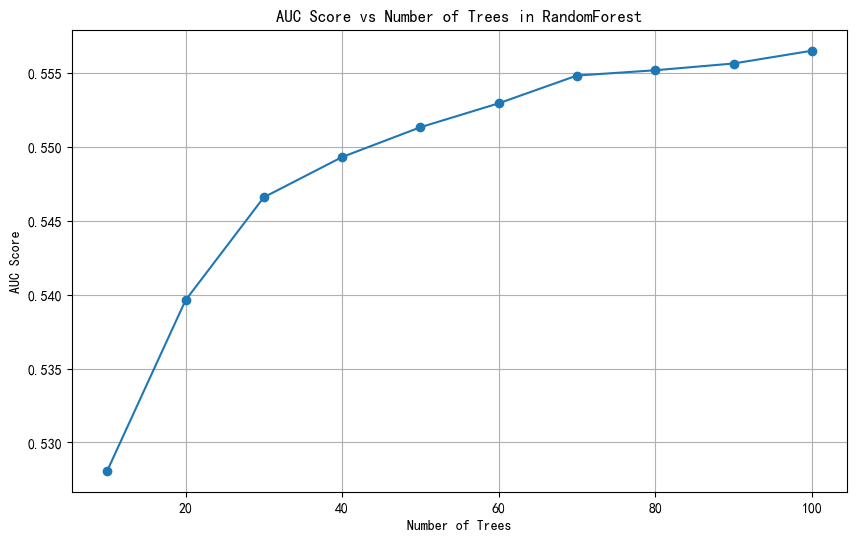

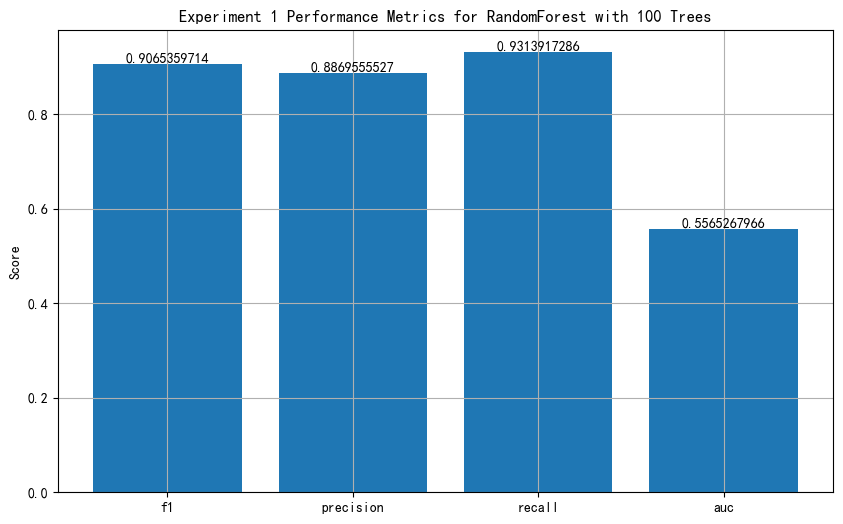

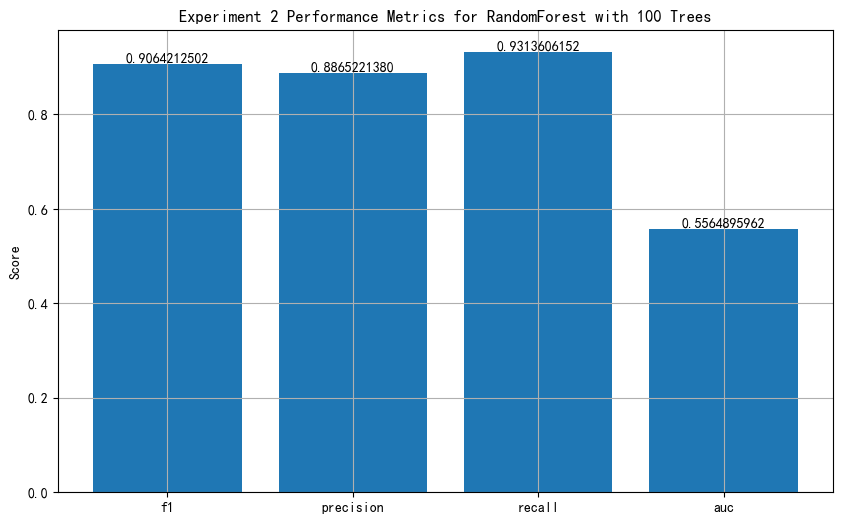

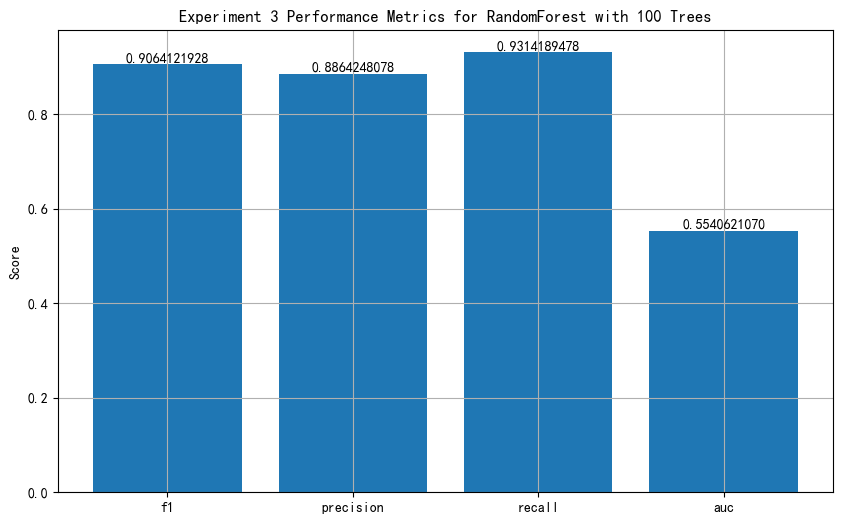

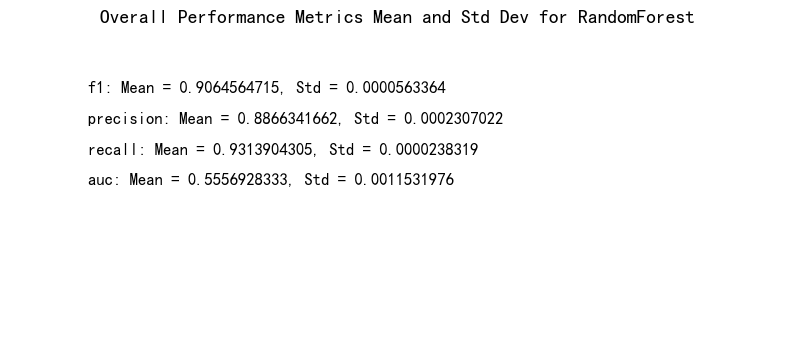

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# 假设 train_data_1 和 target 已经定义
stdScaler = StandardScaler()
X = stdScaler.fit_transform(train_data_1)
y = target

# 定义参数范围
tree_range = range(10, 101, 10)
best_score = 0
best_n_estimators = 0
all_scores = []

# 搜索最优的树数量
for n_trees in tree_range:
    clf = RandomForestClassifier(n_estimators=n_trees, random_state=0)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    auc_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_test_pred_proba = clf.predict_proba(X_test)[:, 1]
        auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))

    mean_auc = np.mean(auc_scores)
    all_scores.append(mean_auc)

    if mean_auc > best_score:
        best_score = mean_auc
        best_n_estimators = n_trees

print(f"Best number of trees: {best_n_estimators} with AUC: {best_score:.10f}")

# 绘制AUC随树数量变化的图
plt.figure(figsize=(10, 6))
plt.plot(tree_range, all_scores, marker='o')
plt.title('AUC Score vs Number of Trees in RandomForest')
plt.xlabel('Number of Trees')
plt.ylabel('AUC Score')
plt.grid(True)
plt.show()

# 使用最优树数量进行实验
clf = RandomForestClassifier(n_estimators=best_n_estimators, random_state=0)

# 进行三次实验
num_experiments = 3
all_scores = []

for exp_num in range(num_experiments):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=exp_num)
    f1_scores, precision_scores, recall_scores, auc_scores = [], [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test)
        y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

        f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        precision_scores.append(precision_score(y_test, y_test_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_test_pred, average='weighted'))
        auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))

    scores = {
        'f1': np.mean(f1_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'auc': np.mean(auc_scores)
    }
    all_scores.append(scores)

    plt.figure(figsize=(10, 6))
    metrics = list(scores.keys())
    values = list(scores.values())
    plt.bar(metrics, values, capsize=5)
    for i, value in enumerate(values):
        plt.text(i, value, f'{value:.10f}', ha='center', va='bottom')
    plt.title(f'Experiment {exp_num + 1} Performance Metrics for RandomForest with {best_n_estimators} Trees')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

# 计算三次实验的均值和标准差
metrics = ['f1', 'precision', 'recall', 'auc']
means = {metric: np.mean([scores[metric] for scores in all_scores]) for metric in metrics}
stds = {metric: np.std([scores[metric] for scores in all_scores]) for metric in metrics}

# 创建一个空白图像
plt.figure(figsize=(10, 4))
plt.axis('off')  # 关闭坐标轴

# 在图像上添加文本
text_y_position = 0.8  # 初始文本的y位置
for metric in metrics:
    text = f"{metric}: Mean = {means[metric]:.10f}, Std = {stds[metric]:.10f}"
    plt.text(0.1, text_y_position, text, fontsize=12, ha='left')
    text_y_position -= 0.1  # 每行文本向下移动

plt.title('Overall Performance Metrics Mean and Std Dev for RandomForest', fontsize=14)
plt.show()

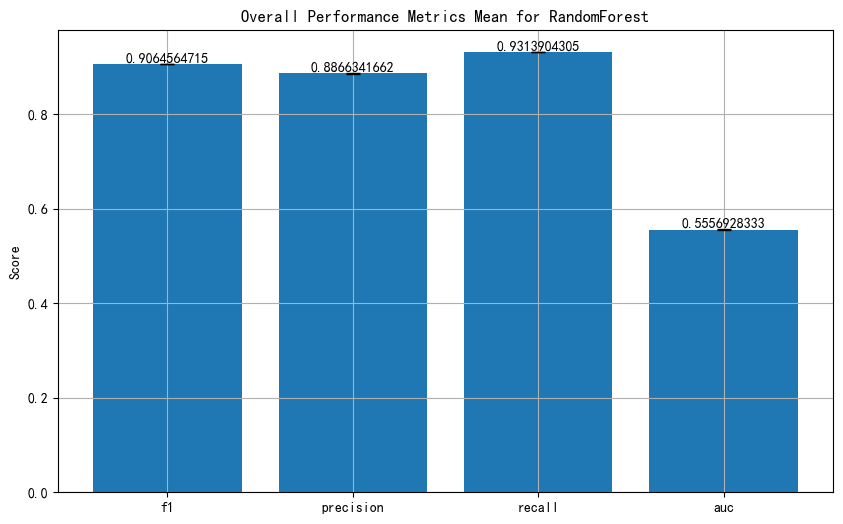

In [126]:
# 绘制均值和标准差
plt.figure(figsize=(10, 6))
plt.bar(metrics, [means[metric] for metric in metrics], yerr=[stds[metric] for metric in metrics], capsize=5)
for i, metric in enumerate(metrics):
    plt.text(i, means[metric], f'{means[metric]:.10f}', ha='center', va='bottom')
plt.title('Overall Performance Metrics Mean for RandomForest')
plt.ylabel('Score')
plt.grid(True)
plt.show()

Best number of estimators: 100 with AUC: 0.6010652461


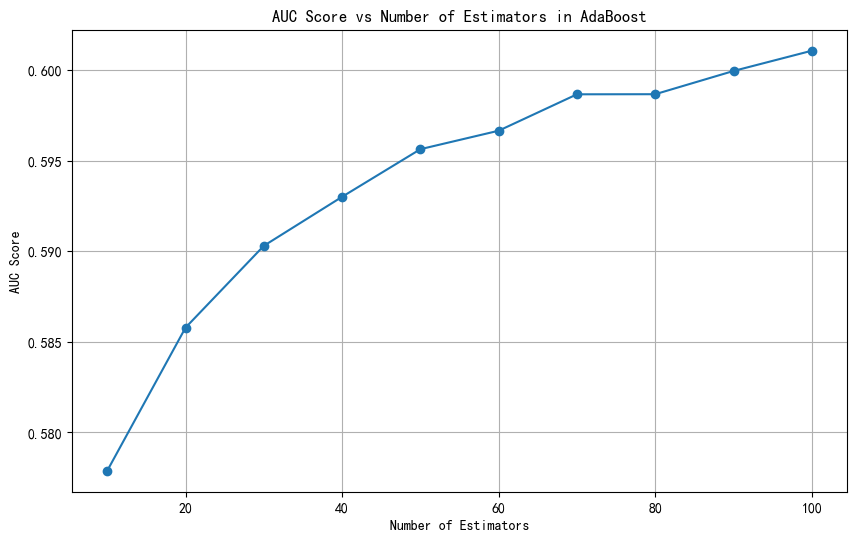

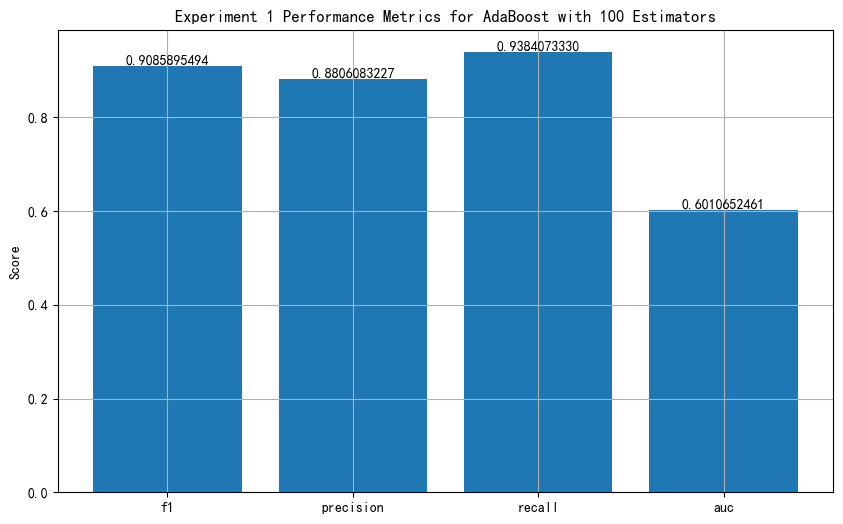

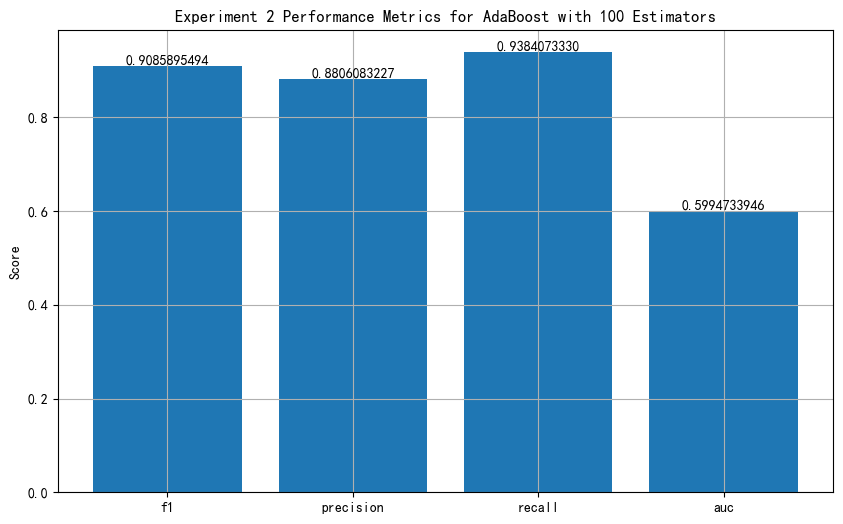

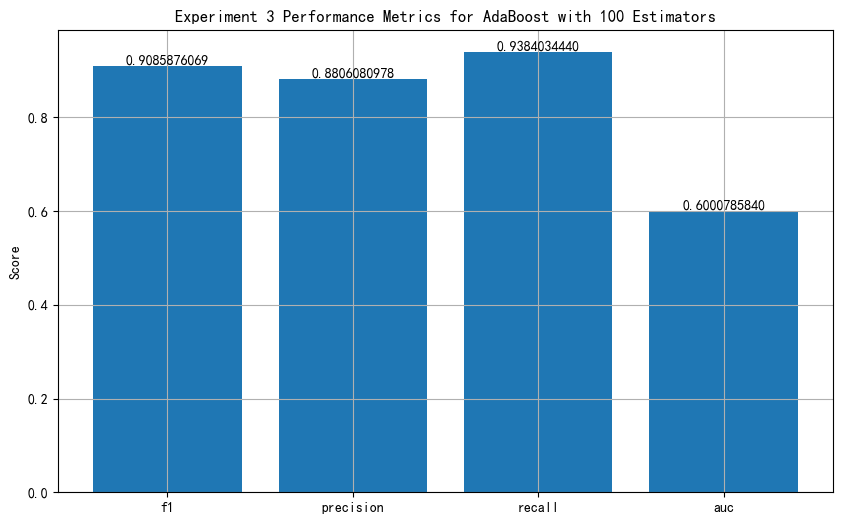

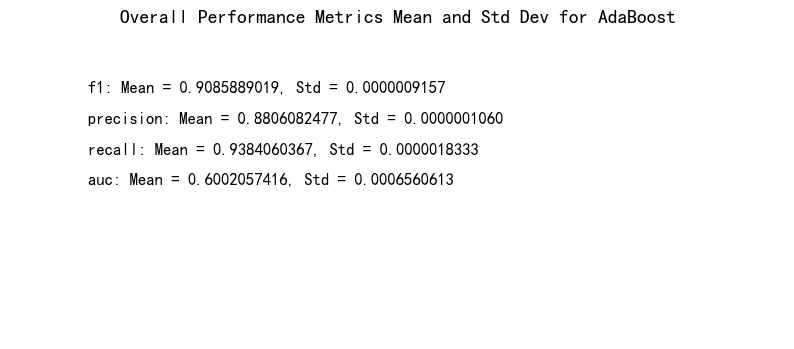

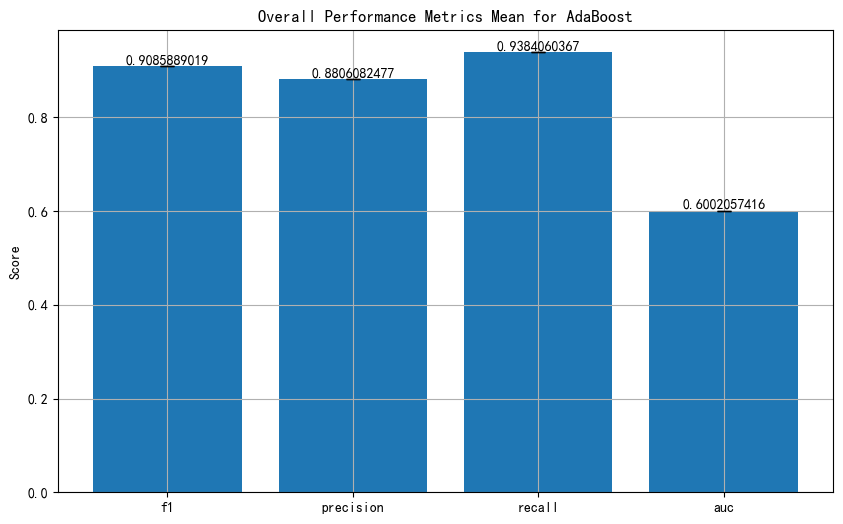

In [131]:


# 假设 train_data_1 和 target 已经定义
stdScaler = StandardScaler()
X = stdScaler.fit_transform(train_data_1)
y = target

# 定义参数范围
n_estimators_range = range(10, 101, 10)
best_score = 0
best_n_estimators = 0
all_scores = []

# 搜索最优的估计器数量
for n_estimators in n_estimators_range:
    # 使用默认的弱分类器（决策树桩）
    clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    auc_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_test_pred_proba = clf.predict_proba(X_test)[:, 1]
        auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))

    mean_auc = np.mean(auc_scores)
    all_scores.append(mean_auc)

    if mean_auc > best_score:
        best_score = mean_auc
        best_n_estimators = n_estimators

print(f"Best number of estimators: {best_n_estimators} with AUC: {best_score:.10f}")

# 绘制AUC随估计器数量变化的图
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, all_scores, marker='o')
plt.title('AUC Score vs Number of Estimators in AdaBoost')
plt.xlabel('Number of Estimators')
plt.ylabel('AUC Score')
plt.grid(True)
plt.show()

# 使用最优估计器数量进行实验
clf = AdaBoostClassifier(n_estimators=best_n_estimators, random_state=0)

# 进行三次实验
num_experiments = 3
all_scores = []

for exp_num in range(num_experiments):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=exp_num)
    f1_scores, precision_scores, recall_scores, auc_scores = [], [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test)
        y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

        f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        precision_scores.append(precision_score(y_test, y_test_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_test_pred, average='weighted'))
        auc_scores.append(roc_auc_score(y_test, y_test_pred_proba))

    scores = {
        'f1': np.mean(f1_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'auc': np.mean(auc_scores)
    }
    all_scores.append(scores)

    plt.figure(figsize=(10, 6))
    metrics = list(scores.keys())
    values = list(scores.values())
    plt.bar(metrics, values, capsize=5)
    for i, value in enumerate(values):
        plt.text(i, value, f'{value:.10f}', ha='center', va='bottom')
    plt.title(f'Experiment {exp_num + 1} Performance Metrics for AdaBoost with {best_n_estimators} Estimators')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

# 计算三次实验的均值和标准差
metrics = ['f1', 'precision', 'recall', 'auc']
means = {metric: np.mean([scores[metric] for scores in all_scores]) for metric in metrics}
stds = {metric: np.std([scores[metric] for scores in all_scores]) for metric in metrics}

# 创建一个空白图像
plt.figure(figsize=(10, 4))
plt.axis('off')  # 关闭坐标轴

# 在图像上添加文本
text_y_position = 0.8  # 初始文本的y位置
for metric in metrics:
    text = f"{metric}: Mean = {means[metric]:.10f}, Std = {stds[metric]:.10f}"
    plt.text(0.1, text_y_position, text, fontsize=12, ha='left')
    text_y_position -= 0.1  # 每行文本向下移动

plt.title('Overall Performance Metrics Mean and Std Dev for AdaBoost', fontsize=14)
plt.show()

# 绘制均值和标准差
plt.figure(figsize=(10, 6))
plt.bar(metrics, [means[metric] for metric in metrics], yerr=[stds[metric] for metric in metrics], capsize=5)
for i, metric in enumerate(metrics):
    plt.text(i, means[metric], f'{means[metric]:.10f}', ha='center', va='bottom')
plt.title('Overall Performance Metrics Mean for AdaBoost')
plt.ylabel('Score')
plt.grid(True)
plt.show()